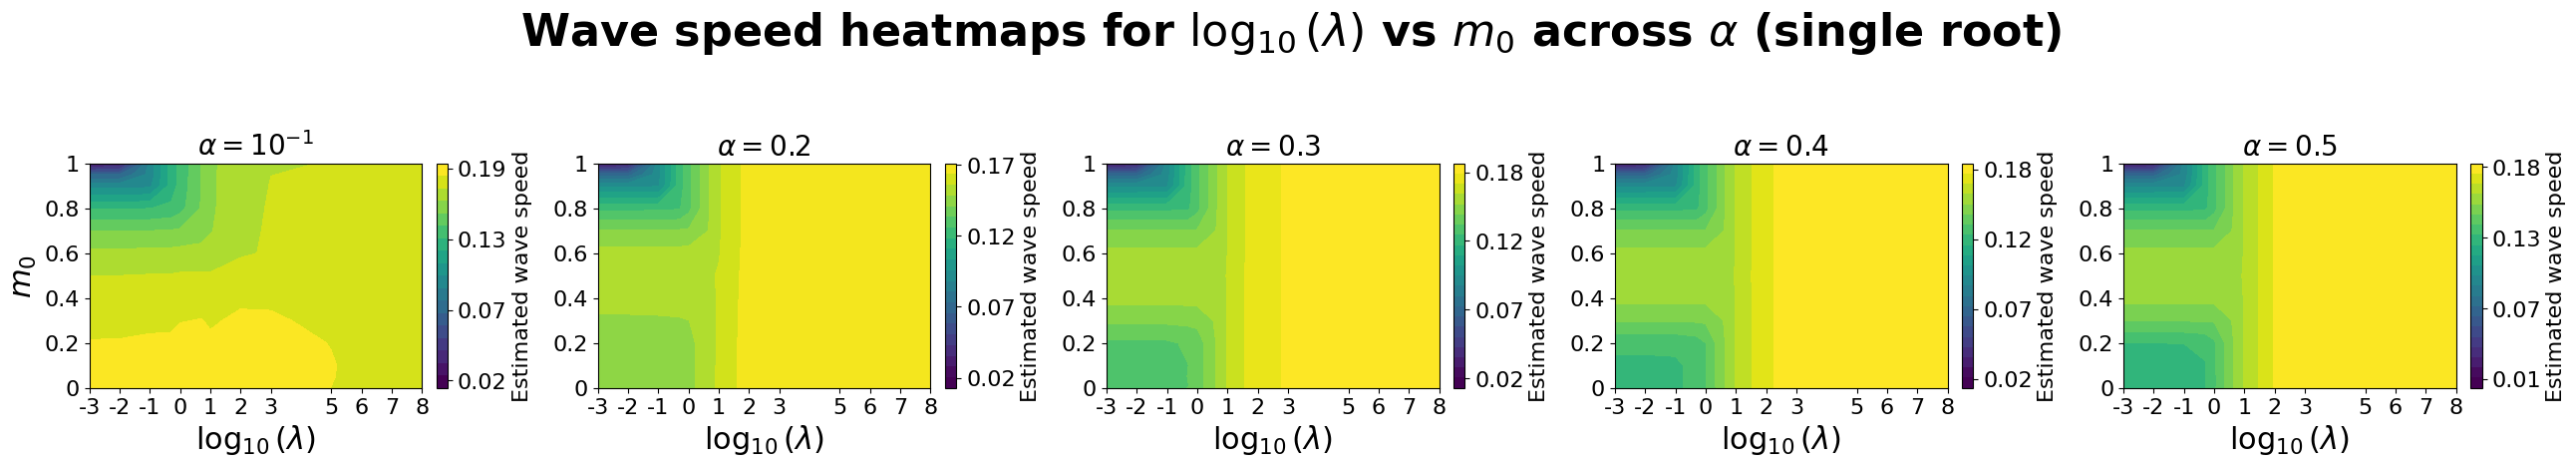

In [20]:
# === Wave-speed heatmaps for fixed α values (single root) =====================
# - Robust token matching: accepts 1e8, 1e+08, 1e08, 100000000, "p" decimals, E/ e.
# - Numeric fallback if exactish token not found.
# - 1×K grid over α in a single root like "speeds_func_alpha_01".
# ==============================================================================

import os, re, json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ------------------------
# Token + directory helpers
# ------------------------
_num_pat = re.compile(r"([0-9eE\.\+\-]+)$")

def _token_variants(v: float):
    """Return many textual variants for v to match folder tokens."""
    v = float(v)
    dec   = f"{v:.12f}".rstrip("0").rstrip(".")         # 100000000
    plain = f"{v:g}"                                    # 1e+08 or 100000000 (matplotlib-style)
    sci   = f"{v:.0e}"                                  # 1e+08
    s, e  = sci.split("e")
    ei    = int(e)                                      # 8 (or -8)
    sci_neat   = f"{s}e{ei}"                            # 1e8
    sci_zpad   = f"{s}e{abs(ei):02d}"                   # 1e08
    sci_sign   = f"{s}e{'+' if ei>=0 else '-'}{abs(ei):02d}"  # 1e+08 / 1e-08

    toks = {dec, plain, sci, sci_neat, sci_zpad, sci_sign}
    # uppercase E variants
    toks |= {t.replace("e", "E") for t in list(toks)}
    # allow decimal "p" variant (e.g., 0p5)
    toks |= {t.replace(".", "p") for t in list(toks)}
    return toks

def _exactish_dir(parent: Path, prefix: str, value: float):
    """Return parent/prefix_<token> if any token matches exactly (string)."""
    if not parent.exists():
        return None
    for tok in _token_variants(value):
        p = parent / f"{prefix}_{tok}"
        if p.is_dir():
            return p
    return None

def _closest_dir_by_number(parent: Path, prefix: str, target: float):
    """Numeric fallback (only used if exactish failed)."""
    if not parent.exists():
        return None
    cands = [d for d in parent.iterdir() if d.is_dir() and d.name.startswith(prefix + "_")]
    if not cands:
        return None
    def take_num(p: Path):
        m = _num_pat.search(p.name)
        if not m:
            return None
        s = m.group(1).replace("p", ".")
        # normalize e/E with optional + sign (float handles both)
        try:
            return float(s)
        except Exception:
            return None
    pairs = [(p, take_num(p)) for p in cands]
    pairs = [(p, v) for p, v in pairs if v is not None]
    if not pairs:
        return None
    return min(pairs, key=lambda pv: abs(pv[1] - float(target)))[0]

# ------------------------
# Speed loader
# ------------------------
def _summary_speed(run_dir: Path, which="N"):
    if run_dir is None:
        return np.nan
    s = run_dir / "summary.json"
    if not s.exists():
        return np.nan
    try:
        meta = json.loads(s.read_text())
    except Exception:
        return np.nan

    w = str(which).upper()
    keys = ["wave_speed", "speed", "c"]               # generic fallbacks
    if w == "N":
        keys = ["speed_N", "c_N"] + keys
    else:
        keys = ["speed_M", "c_M"] + keys

    for k in keys:
        if k in meta:
            try:
                v = float(meta[k])
                if np.isfinite(v):
                    return v
            except Exception:
                pass
    return np.nan

# ------------------------
# Single-root dir resolver
# ------------------------
def _find_dir_single_root(root_dir, lam, alpha, m0):
    """
    Resolve <root>/lambda_*/alpha_*/m0_* inside a single base folder.
    - tries exactish tokens first,
    - then numeric nearest for lambda and alpha,
    - m0 must match exactish (no nearest).
    """
    base = Path(root_dir)
    lam_dir = (_exactish_dir(base, "lambda", lam) or
               _closest_dir_by_number(base, "lambda", lam))
    if lam_dir is None:
        return None
    a_dir = (_exactish_dir(lam_dir, "alpha", alpha) or
             _closest_dir_by_number(lam_dir, "alpha", alpha))
    if a_dir is None:
        return None
    m_dir = _exactish_dir(a_dir, "m0", m0)  # exactish only for m0
    return m_dir

# ------------------------
# Plotter: 1×K grid over α
# ------------------------
def plot_alpha_grid_from_single_root(
    *,
    root_dir="speeds_func_alpha_01",
    alpha_list=(0.1, 0.2, 0.3, 0.4, 0.5),
    lambda_vals=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e5, 1e6, 1e7, 1e8),
    m0_vals=(0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1),
    which_speed="N",
    cmap="viridis",
    levels=20,
    # fonts & layout
    tick_fs=16, label_fs=22, title_fs=20, cbar_fs=16,
    suptitle=r"Wave speed heatmaps for $\log_{10}(\lambda)$ vs $m_0$ across $\alpha$ (single root)",
    suptitle_y=1.02,
    every_other_y_tick=True,
    save=False, outpath=None,
    verbose=True
):
    alpha_list = tuple(float(a) for a in alpha_list)
    lam_arr    = np.asarray(lambda_vals, float)
    m0_arr     = np.asarray(m0_vals,     float)

    X, Y = np.meshgrid(np.log10(lam_arr), m0_arr)

    ncols = len(alpha_list)
    fig_w = 5.2 * ncols
    fig_h = 4.5
    fig, axes = plt.subplots(1, ncols, figsize=(fig_w, fig_h), squeeze=False)
    axes = axes[0]

    total_missing = 0

    for j, a in enumerate(alpha_list):
        ax = axes[j]
        H = np.full((len(m0_arr), len(lam_arr)), np.nan, float)

        # fill matrix
        for i, m0 in enumerate(m0_arr):
            for k, lam in enumerate(lam_arr):
                d = _find_dir_single_root(root_dir, lam, a, m0)
                c = _summary_speed(d, which=which_speed)
                if np.isfinite(c):
                    H[i, k] = c
                else:
                    total_missing += 1

        Hm = np.ma.masked_invalid(H)
        if np.isfinite(Hm).any():
            vmin, vmax = float(np.nanmin(Hm)), float(np.nanmax(Hm))
            if vmin == vmax:
                vmax = vmin + 1e-12
        else:
            vmin, vmax = 0.0, 1.0

        cf = ax.contourf(X, Y, Hm, levels=levels, cmap=cmap, vmin=vmin, vmax=vmax)

        # colorbar (4 ticks)
        cbar = fig.colorbar(cf, ax=ax, fraction=0.046, pad=0.04)
        ticks = [vmin,
                 vmin + (vmax - vmin) / 3.0,
                 vmin + 2.0 * (vmax - vmin) / 3.0,
                 vmax]
        cbar.set_ticks(ticks)
        cbar.set_ticklabels([f"{float(t):.2f}" for t in ticks])
        cbar.ax.tick_params(labelsize=cbar_fs)
        cbar.set_label("Estimated wave speed", fontsize=cbar_fs)

        # title
        if np.isclose(a, 1.0):
            tlabel = r"$\alpha=1$"
        elif np.isclose(a, 10.0):
            tlabel = r"$\alpha=10$"
        else:
            exp = int(np.floor(np.log10(abs(a)))) if a != 0 else 0
            mant = abs(a) / (10**exp) if a != 0 else 0
            if a != 0 and np.isclose(mant, 1.0):
                tlabel = rf"$\alpha=10^{{{exp}}}$"
            elif 1e-2 <= abs(a) <= 1e2:
                tlabel = rf"$\alpha={a:g}$"
            else:
                tlabel = rf"$\alpha={mant:.2g}\times 10^{{{exp}}}$"
        ax.set_title(tlabel, fontsize=title_fs)

        # axes labels
        ax.set_xlabel(r"$\log_{10}(\lambda)$", fontsize=label_fs)
        if j == 0:
            ax.set_ylabel(r"$m_0$", fontsize=label_fs)

        # ticks: decades on x; every-other on y if requested
        xticks = np.unique(np.floor(np.log10(lam_arr)).astype(int))
        ax.set_xticks(xticks)
        ax.set_xticklabels([f"{d:d}" for d in xticks], fontsize=tick_fs)

        yticks = np.linspace(0, 1, 11)  # coarse m0 grid for readability
        if every_other_y_tick:
            yticks = yticks[::2]  # 0, .2, .4, .6, .8, 1
        ax.set_yticks(yticks)
        ax.set_yticklabels([f"{y:.2g}" for y in yticks], fontsize=tick_fs)

    if suptitle:
        fig.suptitle(suptitle, fontsize=label_fs + 10, y=suptitle_y, fontweight="bold")

    fig.tight_layout(rect=[0, 0, 1, 0.93 if suptitle else 1])

    if verbose and total_missing:
        print(f"[info] missing/NaN cells encountered: {total_missing}")

    if save:
        outpath = outpath or "alpha_grid_single_root.png"
        Path(outpath).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(outpath, dpi=300, bbox_inches="tight")
        print(f"[plot] saved to {outpath}")
    else:
        plt.show()

    return fig, axes

# ------------------------
# Example call (your case)
# ------------------------
if __name__ == "__main__":
    lambda_vals = [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100, 1000, 100000, 1000000, 10000000, 100000000]
    alpha_vals  = [0.1, 0.2, 0.3, 0.4, 0.5]
    m0_vals     = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0]

    plot_alpha_grid_from_single_root(
        root_dir="speeds_func_alpha_01",
        alpha_list=alpha_vals,
        lambda_vals=lambda_vals,
        m0_vals=m0_vals,
        which_speed="N",
        cmap="viridis",
        levels=20,
        tick_fs=16, label_fs=22, title_fs=20, cbar_fs=16,
        suptitle=r"Wave speed heatmaps for $\log_{10}(\lambda)$ vs $m_0$ across $\alpha$ (single root)",
        suptitle_y=1.03,
        every_other_y_tick=True,
        save=False,  # set True to write a PNG
        outpath="alpha_grid_single_root.png",
        verbose=True
    )

In [21]:
# --- Bifurcation diagnostics on existing results (single-root store) ---------

import os, re, json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ---------- robust token helpers (same as before) ----------
_num_pat = re.compile(r"([0-9eE\.\+\-]+)$")

def _token_variants(v: float):
    v = float(v)
    dec = f"{v:.12f}".rstrip("0").rstrip(".")
    plain = f"{v:g}"
    sci = f"{v:.0e}"; s,e = sci.split("e"); ei = int(e)
    sci_neat = f"{s}e{ei}"
    sci_zpad = f"{s}e{abs(ei):02d}"
    sci_sign = f"{s}e{'+' if ei>=0 else '-'}{abs(ei):02d}"
    toks = {dec, plain, sci, sci_neat, sci_zpad, sci_sign}
    toks |= {t.replace("e","E") for t in list(toks)}
    toks |= {t.replace(".","p") for t in list(toks)}
    return toks

def _exactish_dir(parent: Path, prefix: str, value: float):
    if not parent.exists(): return None
    for tok in _token_variants(value):
        p = parent / f"{prefix}_{tok}"
        if p.is_dir():
            return p
    return None

def _closest_dir_by_number(parent: Path, prefix: str, target: float):
    if not parent.exists(): return None
    cands = [d for d in parent.iterdir() if d.is_dir() and d.name.startswith(prefix + "_")]
    if not cands: return None
    def take_num(p: Path):
        m = _num_pat.search(p.name)
        if not m: return None
        s = m.group(1).replace("p",".")
        try: return float(s)
        except: return None
    pairs = [(p, take_num(p)) for p in cands]
    pairs = [(p,v) for p,v in pairs if v is not None]
    if not pairs: return None
    return min(pairs, key=lambda pv: abs(pv[1]-float(target)))[0]

def _find_dir_single_root(root_dir, lam, alpha, m0):
    base = Path(root_dir)
    lam_dir = _exactish_dir(base, "lambda", lam) or _closest_dir_by_number(base, "lambda", lam)
    if lam_dir is None: return None
    a_dir = _exactish_dir(lam_dir, "alpha", alpha) or _closest_dir_by_number(lam_dir, "alpha", alpha)
    if a_dir is None: return None
    return _exactish_dir(a_dir, "m0", m0)  # m0 exactish

def _summary_speed(run_dir: Path, which="N"):
    if run_dir is None: return np.nan
    s = run_dir / "summary.json"
    if not s.exists(): return np.nan
    try:
        meta = json.loads(s.read_text())
    except Exception:
        return np.nan
    keys = ["wave_speed","speed","c"]
    if str(which).upper()=="N":
        keys = ["speed_N","c_N"] + keys
    else:
        keys = ["speed_M","c_M"] + keys
    for k in keys:
        if k in meta:
            try:
                v = float(meta[k])
                if np.isfinite(v): return v
            except: pass
    return np.nan

# ---------- 1) dense c(α) curves in a window ----------
def plot_c_vs_alpha_window(
    *,
    root_dir="speeds_func_alpha_01",
    alpha_window=(0.08, 0.6),
    n_alpha=120,                   # dense sampling
    lambdas=(0.1, 1, 10, 100, 1e4),
    m0_vals=(0.2, 0.5, 0.9),
    which_speed="N",
    tick_fs=13, label_fs=16, title_fs=18, legend_fs=12,
    suptitle=r"$c$ vs $\log_{10}(\alpha)$ (dense window)",
):
    a_lo, a_hi = alpha_window
    alphas = np.geomspace(a_lo, a_hi, n_alpha)  # log spacing is usually better
    loga   = np.log10(alphas)

    ncols = len(lambdas)
    fig, axes = plt.subplots(1, ncols, figsize=(5.2*ncols, 4.5), squeeze=False)
    axes = axes[0]

    cmap = plt.get_cmap("viridis")
    colors = [cmap(i/max(1,len(m0_vals)-1)) for i in range(len(m0_vals))]

    for j, lam in enumerate(lambdas):
        ax = axes[j]
        for k, m0 in enumerate(m0_vals):
            cvals = []
            for a in alphas:
                d = _find_dir_single_root(root_dir, lam, a, m0)
                c = _summary_speed(d, which=which_speed)
                cvals.append(c if np.isfinite(c) else np.nan)
            cvals = np.asarray(cvals, float)

            # finite-difference jump detection (simple)
            dc = np.abs(np.diff(cvals))
            # mark indices where jump exceeds a robust threshold (median+5*mad)
            med = np.nanmedian(dc); mad = np.nanmedian(np.abs(dc - med))
            thr = med + 5*mad if np.isfinite(mad) else np.nanmax(dc) * 0.2
            jump_idx = np.where(dc > thr)[0]

            ax.plot(loga, cvals, "-o", ms=3, lw=1.8, color=colors[k], label=rf"$m_0={m0:g}$")
            # overlay jump markers
            if len(jump_idx):
                ax.plot(loga[jump_idx+1], cvals[jump_idx+1], "o", ms=6, mfc="none", mec="red", mew=1.5)

        ax.set_title(rf"$\lambda={lam:g}$", fontsize=title_fs, fontweight="bold")
        ax.set_xlabel(r"$\log_{10}(\alpha)$", fontsize=label_fs)
        if j == 0:
            ax.set_ylabel(r"Wave speed $c$", fontsize=label_fs)
        ax.grid(True, ls="--", alpha=0.25)
        ax.tick_params(labelsize=tick_fs)

    fig.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), fontsize=legend_fs, title=r"$m_0$", title_fontsize=legend_fs)
    fig.suptitle(suptitle, fontsize=label_fs+8, fontweight="bold", y=1.02)
    fig.tight_layout(rect=[0,0,0.95,0.92])
    plt.show()
    return fig, axes

# ---------- 2) jump map: where |Δc/Δlog10 α| is large ----------
def plot_alpha_lambda_jumpmap(
    *,
    root_dir="speeds_func_alpha_01",
    alpha_list=(0.08, 0.1, 0.12, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6),
    lambda_vals=(0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100, 1000, 1e5, 1e6, 1e7, 1e8),
    m0=0.5,                         # choose a representative m0
    which_speed="N",
    levels=20,
    tick_fs=13, label_fs=16, title_fs=18,
    cmap="magma",
    suptitle=r"Jump map: $\max|\Delta c|$ along $\log_{10}\alpha$"
):
    alphas = np.asarray(alpha_list, float)
    lam_arr = np.asarray(lambda_vals, float)
    loga = np.log10(alphas)
    logl = np.log10(lam_arr)

    # build c(alpha, lambda) for fixed m0
    C = np.full((len(alphas), len(lam_arr)), np.nan, float)
    for i, a in enumerate(alphas):
        for j, lam in enumerate(lam_arr):
            d = _find_dir_single_root(root_dir, lam, a, m0)
            C[i, j] = _summary_speed(d, which=which_speed)

    # compute max finite difference along alpha for each lambda
    DC = np.nanmax(np.abs(np.diff(C, axis=0)), axis=0)  # size = len(lam_arr)

    # expand to a surface for plotting (repeat along alpha just for contours)
    DCsurf = np.tile(DC, (len(alphas), 1))

    fig, ax = plt.subplots(1, 1, figsize=(7, 4.8))
    cf = ax.contourf(logl[None, :].repeat(len(alphas), axis=0),
                     loga[:, None].repeat(len(lam_arr), axis=1),
                     DCsurf, levels=levels, cmap=cmap)
    cbar = fig.colorbar(cf, ax=ax)
    cbar.set_label(r"$\max|\Delta c|$ along $\log_{10}\alpha$", fontsize=label_fs)
    ax.set_xlabel(r"$\log_{10}(\lambda)$", fontsize=label_fs)
    ax.set_ylabel(r"$\log_{10}(\alpha)$", fontsize=label_fs)
    ax.tick_params(labelsize=tick_fs)
    ax.set_title(rf"$m_0={m0:g}$", fontsize=title_fs)
    fig.suptitle(suptitle, fontsize=label_fs+8, fontweight="bold", y=1.02)
    fig.tight_layout(rect=[0,0,1,0.92])
    plt.show()
    return fig, ax

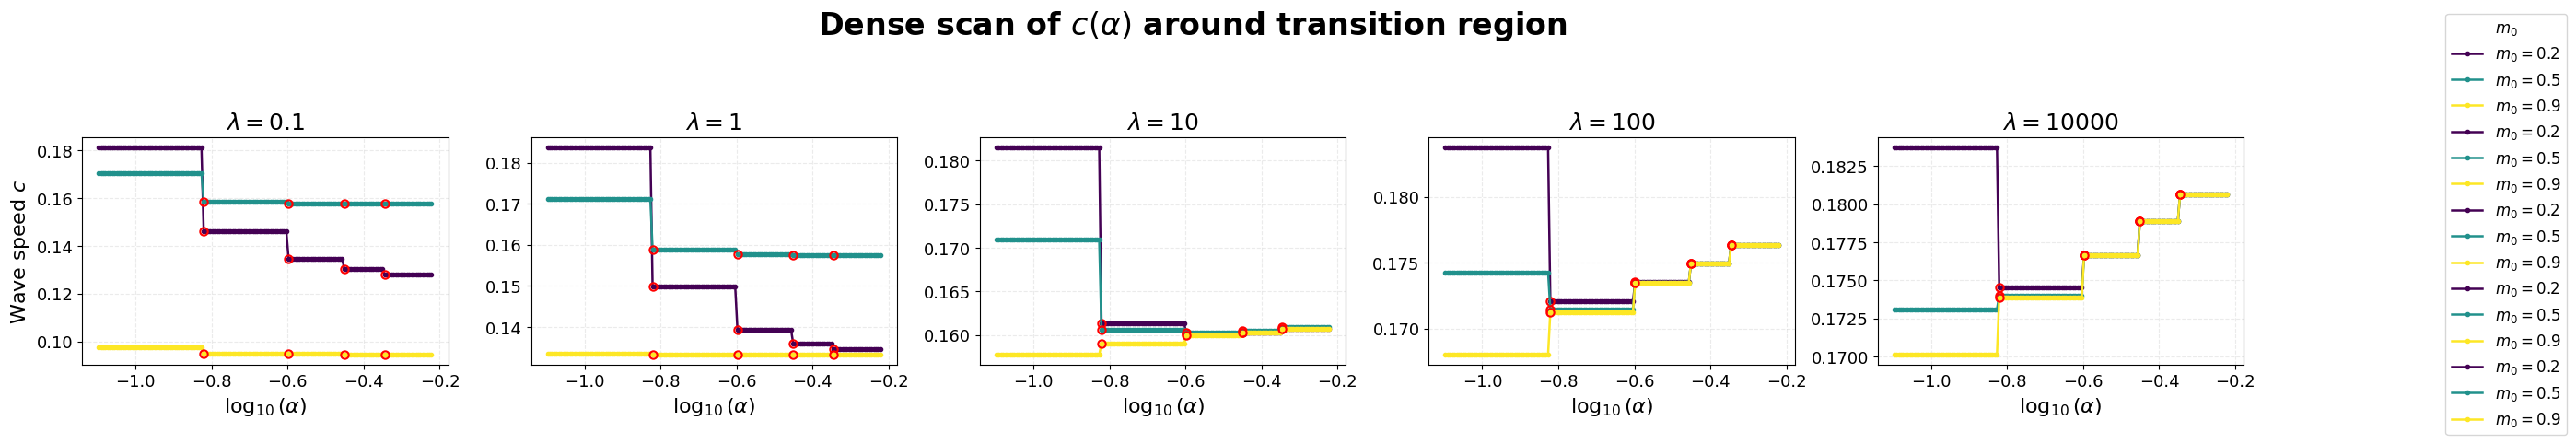

(<Figure size 2600x450 with 5 Axes>,
 array([<Axes: title={'center': '$\\lambda=0.1$'}, xlabel='$\\log_{10}(\\alpha)$', ylabel='Wave speed $c$'>,
        <Axes: title={'center': '$\\lambda=1$'}, xlabel='$\\log_{10}(\\alpha)$'>,
        <Axes: title={'center': '$\\lambda=10$'}, xlabel='$\\log_{10}(\\alpha)$'>,
        <Axes: title={'center': '$\\lambda=100$'}, xlabel='$\\log_{10}(\\alpha)$'>,
        <Axes: title={'center': '$\\lambda=10000$'}, xlabel='$\\log_{10}(\\alpha)$'>],
       dtype=object))

In [22]:
# === Dense c(α) curves for selected λ, m0 ===
plot_c_vs_alpha_window(
    root_dir="speeds_func_alpha_01",
    alpha_window=(0.08, 0.6),   # zoom in around the suspected transition
    n_alpha=150,                # more points for detail
    lambdas=(0.1, 1, 10, 100, 1e4),   # pick a representative set of λ
    m0_vals=(0.2, 0.5, 0.9),    # try low, mid, and high m0
    which_speed="N",
    suptitle=r"Dense scan of $c(\alpha)$ around transition region"
)

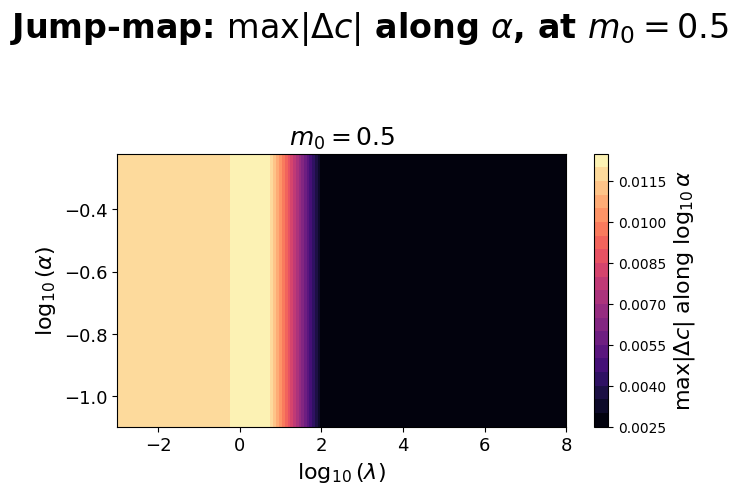

(<Figure size 700x480 with 2 Axes>,
 <Axes: title={'center': '$m_0=0.5$'}, xlabel='$\\log_{10}(\\lambda)$', ylabel='$\\log_{10}(\\alpha)$'>)

In [23]:
# === Jump-map (where c(α) changes sharply) ===
plot_alpha_lambda_jumpmap(
    root_dir="speeds_func_alpha_01",
    alpha_list=np.linspace(0.08, 0.6, 40),   # dense α in the transition region
    lambda_vals=[0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100, 1e3, 1e5, 1e6, 1e7, 1e8],
    m0=0.5,                   # focus on a representative mid m0
    which_speed="N",
    suptitle=r"Jump-map: $\max|\Delta c|$ along $\alpha$, at $m_0=0.5$"
)

In [24]:
# =============================
# Bifurcation diagnostics toolkit
# =============================
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from pathlib import Path
import json, os

# ------------------------------------------------------------------
# --- (Safe) fallbacks if your helpers aren't already defined ------
# ------------------------------------------------------------------
def _safe_has(name):  # check if a helper is defined in the session
    return name in globals() and callable(globals()[name])

# token helpers (only used if your own versions are missing)
def _fmt_exact(v):
    v = float(v)
    if v.is_integer(): return str(int(v))
    s = f"{v:.12f}".rstrip("0").rstrip(".")
    return "0" if s == "-0" else s

def _fallback_augment_roots_by_m0(base_dirs, m0):
    if isinstance(base_dirs, (str, os.PathLike)):
        base_dirs = (base_dirs,)
    roots = [str(b) for b in base_dirs]
    if os.path.isdir("speeds_func_4"):
        roots = ["speeds_func_4"] + roots
    want  = "speeds_func_u" if float(m0) >= 0.5 else "speeds_func_l"
    other = "speeds_func_l" if want == "speeds_func_u" else "speeds_func_u"
    ordered = [r for r in (want, other) if r in roots] + [r for r in roots if r not in (want, other)]
    seen, out = set(), []
    for r in ordered:
        if r not in seen: seen.add(r); out.append(r)
    return tuple(out)

def _fallback_find_source_dir_multi(roots, fixed_lambda, alpha, m0):
    roots = (_augment_roots_by_m0 if _safe_has("_augment_roots_by_m0") else _fallback_augment_roots_by_m0)(roots, m0)
    # exact-style layout only: <root>/lambda_<val>/alpha_<val>/m0_<val>
    for root in roots:
        lam_dir = Path(root) / f"lambda_{_fmt_exact(fixed_lambda)}"
        if not lam_dir.is_dir(): continue
        a_dir   = lam_dir / f"alpha_{_fmt_exact(alpha)}"
        if not a_dir.is_dir():   continue
        m_dir   = a_dir / f"m0_{_fmt_exact(m0)}"
        if m_dir.is_dir(): return m_dir
    return None

def _fallback_summary_speed(run_dir: Path, which="N"):
    if run_dir is None: return np.nan
    s = Path(run_dir) / "summary.json"
    if not s.exists(): return np.nan
    try:
        meta = json.loads(s.read_text())
    except Exception:
        return np.nan
    keys = ("speed_N","c_N","wave_speed","speed","c") if str(which).upper()=="N" \
           else ("speed_M","c_M","wave_speed","speed","c")
    for k in keys:
        if k in meta:
            try:
                v = float(meta[k])
                if np.isfinite(v): return v
            except: pass
    return np.nan

# wire the helpers (prefer your versions if present)
_augment_roots_by_m0      = globals().get("_augment_roots_by_m0", _fallback_augment_roots_by_m0)
_find_source_dir_multi    = globals().get("_find_source_dir_multi", _fallback_find_source_dir_multi)
_summary_speed            = globals().get("_summary_speed", _fallback_summary_speed)

# -----------------------------------------------------------
# ---- Core accessor: c(lam, alpha, m0) from your folders ---
# -----------------------------------------------------------
def get_speed_from_store(base_dirs, lam, alpha, m0, which_speed="N"):
    """Return wave speed c for a triple (λ,α,m0). np.nan if missing."""
    d = _find_source_dir_multi(base_dirs, lam, alpha, m0)
    return float(_summary_speed(d, which=which_speed))

# -----------------------------------------------------------
# 1) Hysteresis: sweep α up vs down at fixed λ, m0
# -----------------------------------------------------------
def sweep_alpha_curve(
    base_dirs, lam, m0,
    alpha_vals_up, alpha_vals_down=None, which_speed="N",
    tick_fs=12, label_fs=16, title_fs=18, legend_fs=12,
    show=True
):
    """
    Compute and optionally plot c(α) with two directions:
      - up:  alpha_vals_up order
      - down: alpha_vals_down (reverse order if None -> reversed up)
    """
    alpha_up = np.asarray(alpha_vals_up, float)
    c_up = np.array([get_speed_from_store(base_dirs, lam, a, m0, which_speed) for a in alpha_up], float)

    if alpha_vals_down is None:
        alpha_down = alpha_up[::-1].copy()
    else:
        alpha_down = np.asarray(alpha_vals_down, float)
    c_down = np.array([get_speed_from_store(base_dirs, lam, a, m0, which_speed) for a in alpha_down], float)

    # plot
    fig, ax = plt.subplots(figsize=(6.6, 4.0))
    ax.plot(np.log10(alpha_up),   c_up,   "-o", label="up sweep",   ms=4)
    ax.plot(np.log10(alpha_down), c_down, "--o", label="down sweep",ms=4)
    ax.set_xlabel(r"$\log_{10}(\alpha)$", fontsize=label_fs)
    ax.set_ylabel(r"Wave speed $c$", fontsize=label_fs)
    ax.set_title(rf"Hysteresis test at $\lambda={lam:g}$, $m_0={m0:g}$", fontsize=title_fs, fontweight="bold")
    ax.grid(True, ls="--", alpha=0.3)
    ax.tick_params(labelsize=tick_fs)
    ax.legend(fontsize=legend_fs)
    if show: plt.show()
    return {
        "alpha_up": alpha_up, "c_up": c_up,
        "alpha_down": alpha_down, "c_down": c_down,
        "fig": fig, "ax": ax
    }

# -----------------------------------------------------------
# 2) Jump-map: max |Δc| along α for each λ (single m0)
# -----------------------------------------------------------
def jump_map_alpha(
    base_dirs, lambda_vals, alpha_vals, m0,
    which_speed="N", cmap="magma",
    tick_fs=12, label_fs=16, title_fs=22, cbar_fs=12,
    suptitle=r"Jump-map: $\max|\Delta c|$ along $\alpha$",
    show=True
):
    lamb = np.asarray(lambda_vals, float)
    alps = np.asarray(alpha_vals,  float)
    L = len(lamb); A = len(alps)

    # Precompute speeds
    C = np.full((A, L), np.nan, float)  # rows=alpha, cols=lambda
    for j, lam in enumerate(lamb):
        for i, a in enumerate(alps):
            C[i, j] = get_speed_from_store(base_dirs, lam, a, m0, which_speed)

    # Δ along alpha (row-wise); take max |Δ|
    jumps = np.nanmax(np.abs(np.diff(C, axis=0)), axis=0)  # shape (L,)

    # plot heat-style panel: we show as a 2D “tile” with α on y to match your figure
    X, Y = np.meshgrid(np.log10(lamb), np.log10(alps))
    # To visualize max jump at each λ along α, repeat the vector along y:
    J = np.tile(jumps[None, :], (A, 1))

    fig, ax = plt.subplots(figsize=(6.5, 4.5))
    im = ax.pcolormesh(X, Y, J, shading="auto", cmap=cmap)
    cbar = fig.colorbar(im, ax=ax, pad=0.02)
    cbar.set_label(r"$\max|\Delta c|$ along $\log_{10}\alpha$", fontsize=cbar_fs)
    cbar.ax.tick_params(labelsize=cbar_fs)

    ax.set_xlabel(r"$\log_{10}(\lambda)$", fontsize=label_fs)
    ax.set_ylabel(r"$\log_{10}(\alpha)$", fontsize=label_fs)
    ax.set_title(rf"{suptitle}, at $m_0={m0:g}$", fontsize=title_fs, fontweight="bold")
    ax.tick_params(labelsize=tick_fs)
    ax.grid(True, ls="--", alpha=0.15)
    if show: plt.show()
    return {"lambda_vals": lamb, "alpha_vals": alps, "C": C, "max_jump_per_lambda": jumps, "fig": fig, "ax": ax}

# -----------------------------------------------------------
# 3) Refined jump-map in a focused window (log-spaced)
# -----------------------------------------------------------
def refined_jump_map_alpha_window(
    base_dirs,
    lambda_min=1, lambda_max=100, n_lambda=60,
    alpha_min=0.05, alpha_max=0.6, n_alpha=60,
    m0=0.5, which_speed="N", cmap="magma",
    **style
):
    lamb = np.logspace(np.log10(lambda_min), np.log10(lambda_max), n_lambda)
    alps = np.logspace(np.log10(alpha_min), np.log10(alpha_max), n_alpha)
    return jump_map_alpha(base_dirs, lamb, alps, m0, which_speed=which_speed, cmap=cmap, **style)

# -----------------------------------------------------------
# 4) Locate jump: argmax |Δc| in α for each λ (single m0)
# -----------------------------------------------------------
def locate_jump_along_alpha(base_dirs, lambda_vals, alpha_vals, m0, which_speed="N"):
    lamb = np.asarray(lambda_vals, float)
    alps = np.asarray(alpha_vals,  float)
    A = len(alps)
    # Speeds matrix
    C = np.full((A, len(lamb)), np.nan, float)
    for j, lam in enumerate(lamb):
        for i, a in enumerate(alps):
            C[i, j] = get_speed_from_store(base_dirs, lam, a, m0, which_speed)
    # differences along alpha
    dC = np.abs(np.diff(C, axis=0))  # shape (A-1, L)
    idx = np.nanargmax(dC, axis=0)   # index of biggest jump per lambda
    alpha_star = alps[idx]           # α location of largest jump (left edge)
    jump_size  = dC[idx, np.arange(len(lamb))]
    return {"alpha_star": alpha_star, "jump_size": jump_size, "C": C}

# -----------------------------------------------------------
# 5) Dense panels of c(α) around transition, for many λ, m0
# -----------------------------------------------------------
def dense_alpha_panels(
    base_dirs, lambda_list, alpha_dense,
    m0_list=(0.2, 0.5, 0.9), which_speed="N",
    ms=4, lw=2,
    tick_fs=11, label_fs=13, title_fs=14, legend_fs=11,
    suptitle=r"Dense scan of $c(\alpha)$ around transition region",
    show=True
):
    alpha_dense = np.asarray(alpha_dense, float)
    ncols = len(lambda_list)
    fig, axes = plt.subplots(1, ncols, figsize=(5.0*ncols, 3.6), squeeze=False)
    axes = axes[0]

    colors = plt.get_cmap("viridis")(np.linspace(0, 1, len(m0_list)))
    handles = []
    for j, lam in enumerate(lambda_list):
        ax = axes[j]
        for k, m0 in enumerate(m0_list):
            cs = [get_speed_from_store(base_dirs, lam, a, m0, which_speed) for a in alpha_dense]
            h, = ax.plot(np.log10(alpha_dense), cs, "-o", lw=lw, ms=ms, color=colors[k], label=rf"$m_0={m0:g}$")
            if j == 0: handles.append(h)
        ax.set_title(rf"$\lambda={lam:g}$", fontsize=title_fs)
        ax.set_xlabel(r"$\log_{10}(\alpha)$", fontsize=label_fs)
        if j == 0:
            ax.set_ylabel(r"Wave speed $c$", fontsize=label_fs)
        ax.grid(True, ls="--", alpha=0.3)
        ax.tick_params(labelsize=tick_fs)

    # shared legend on the right
    fig.legend(handles, [h.get_label() for h in handles],
               title=r"$m_0$", fontsize=legend_fs, title_fontsize=legend_fs,
               loc="center left", bbox_to_anchor=(1.02, 0.5))
    fig.tight_layout(rect=[0, 0, 0.95, 0.9])
    fig.suptitle(suptitle, fontsize=label_fs+8, fontweight="bold", y=0.98)
    if show: plt.show()
    return fig, axes

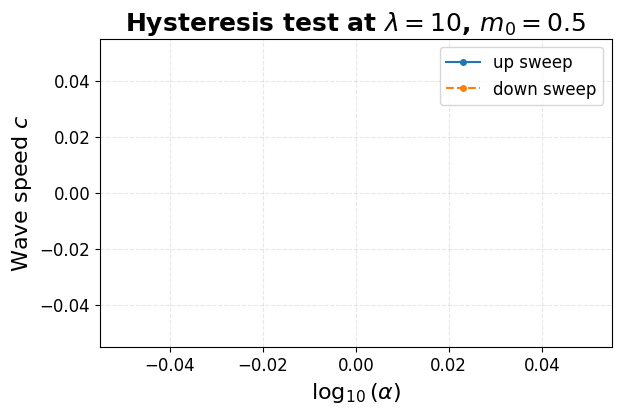

In [25]:
alpha_up   = np.logspace(-2.2, -0.2, 25)  #  ~0.0063 .. 0.63
res = sweep_alpha_curve(
    base_dirs=("speeds_func_l","speeds_func_u","speeds_func_4","speeds_func_alpha_01"),
    lam=10, m0=0.5,
    alpha_vals_up=alpha_up     # down-sweep is automatic (reverse of up)
)

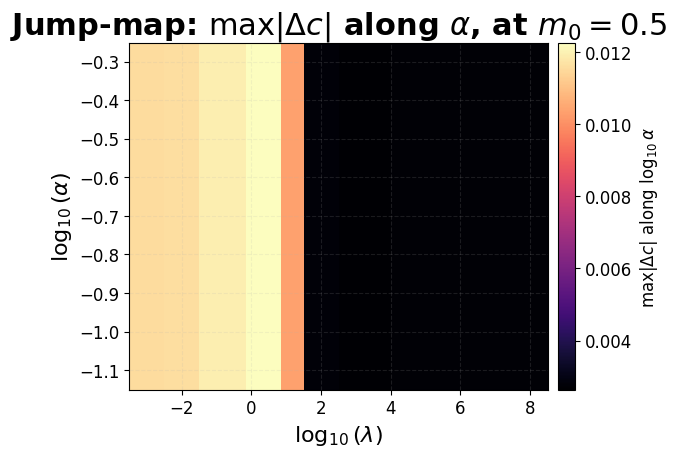

In [26]:
lambda_vals = [1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e5, 1e6, 1e7, 1e8]
alpha_vals  = [0.1, 0.2, 0.3, 0.4, 0.5]
_ = jump_map_alpha(
    base_dirs=("speeds_func_alpha_01",),  # single root that holds these α runs
    lambda_vals=lambda_vals,
    alpha_vals=alpha_vals,
    m0=0.5,
    suptitle=r"Jump-map: $\max|\Delta c|$ along $\alpha$",
)

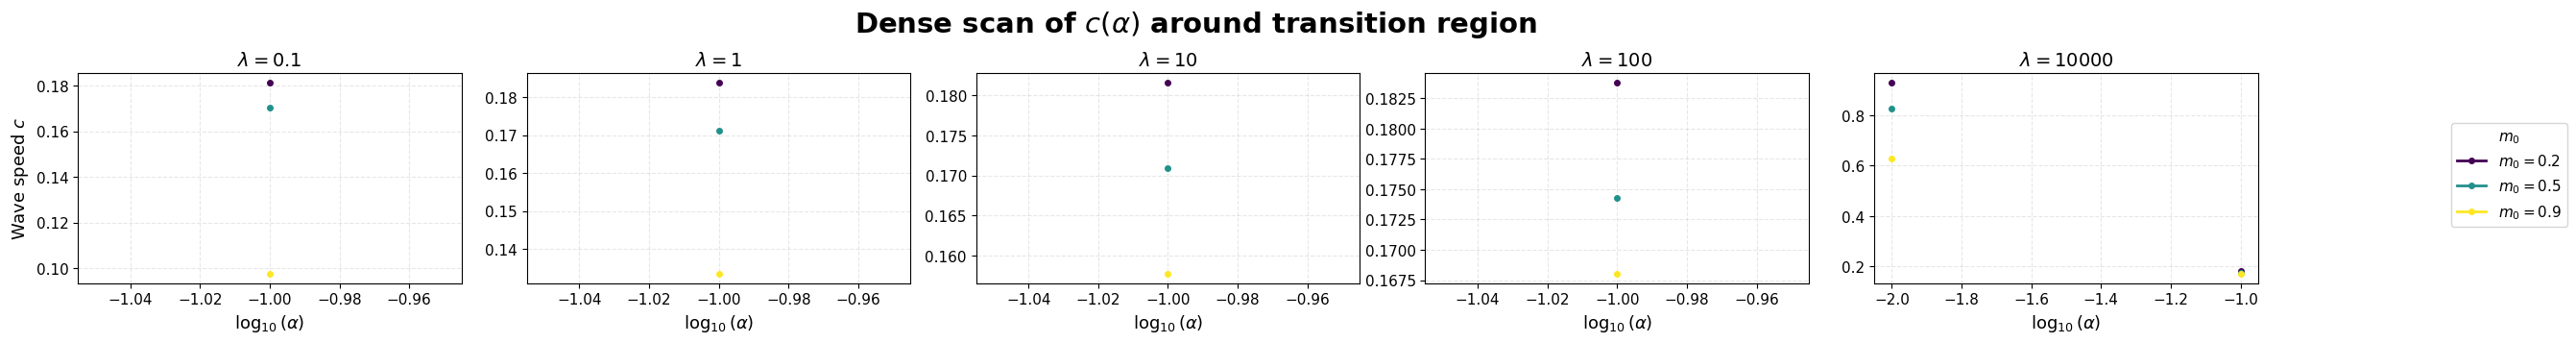

In [ ]:
fig, axes = dense_alpha_panels(
    base_dirs=("speeds_func_alpha_01",),
    lambda_list=[0.1, 1, 10, 100, 1e4],
    alpha_dense=np.logspace(-2.2, -0.2, 21),
    m0_list=(0.2, 0.5, 0.9)
)

In [ ]:
import os, re, json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ----------------- minimal helpers (self-contained) -----------------
_NUM_PAT = re.compile(r"([0-9eE.\-]+)$")

def _token_variants(v: float):
    """Generate folder token variants: 0.5, 5e-1, 0.5 trimmed, and 0p5 form."""
    v = float(v)
    dec   = f"{v:.12f}".rstrip("0").rstrip(".")
    plain = f"{v:g}"
    sci   = f"{v:.0e}"; s,e = sci.split("e"); sci_neat = f"{s}e{int(e)}"
    toks = {dec, plain, sci, sci_neat}
    toks |= {t.replace(".", "p") for t in list(toks)}  # allow 0p5 style
    return toks

def _exactish_dir(parent: Path, prefix: str, value: float):
    """Return parent/prefix_<token> if any token matches exactly (string)."""
    if not parent.exists(): return None
    for tok in _token_variants(value):
        p = parent / f"{prefix}_{tok}"
        if p.is_dir(): return p
    return None

def _closest_dir_by_number(parent: Path, prefix: str, target: float):
    """Numeric fallback ONLY if exactish failed (useful for rounding mismatches)."""
    if not parent.exists(): return None
    cands = [d for d in parent.iterdir() if d.is_dir() and d.name.startswith(prefix + "_")]
    if not cands: return None
    def take_num(p: Path):
        m = _NUM_PAT.search(p.name)
        try: return float(m.group(1)) if m else None
        except: return None
    pairs = [(p, take_num(p)) for p in cands]
    pairs = [(p,v) for p,v in pairs if v is not None]
    if not pairs: return None
    return min(pairs, key=lambda pv: abs(pv[1]-float(target)))[0]

def _summary_speed(run_dir: Path, which="N"):
    """Read speed from summary.json in run_dir."""
    if run_dir is None: return np.nan
    s = run_dir / "summary.json"
    if not s.exists(): return np.nan
    try:
        meta = json.loads(s.read_text())
        keys = ("speed_N","c_N","wave_speed","speed","c") if str(which).upper()=="N" \
               else ("speed_M","c_M","wave_speed","speed","c")
        for k in keys:
            if k in meta:
                try:
                    v = float(meta[k])
                    if np.isfinite(v): return v
                except: pass
    except: pass
    return np.nan

def _find_dir(roots, lam, alpha, m0):
    """
    Look for <root>/lambda_*/alpha_*/m0_* in the given roots (tuple or string),
    using exactish token matching; lambda/alpha may fall back to nearest numeric.
    This version is *not* split by _l/_u families – it’s for speeds_func_alpha_01.
    """
    if isinstance(roots, (str, os.PathLike)): roots = (roots,)
    for root in roots:
        base = Path(root)
        lam_dir = _exactish_dir(base, "lambda", lam) or _closest_dir_by_number(base, "lambda", lam)
        if lam_dir is None: continue
        a_dir = _exactish_dir(lam_dir, "alpha", alpha) or _closest_dir_by_number(lam_dir, "alpha", alpha)
        if a_dir is None: continue
        m_dir = _exactish_dir(a_dir, "m0", m0)   # m0 must match exactly-ish
        if m_dir is not None: return m_dir
    return None

# ----------------- diagnostics + robust jump locator -----------------
def _coverage_table(C, lamb, alps):
    all_nan, some_nan, ok = [], [], []
    for j, lam in enumerate(lamb):
        col = C[:, j]
        if np.all(np.isnan(col)):   all_nan.append(lam)
        elif np.any(np.isnan(col)): some_nan.append(lam)
        else:                       ok.append(lam)
    print(f"[coverage] λ with ALL NaN: {all_nan}")
    print(f"[coverage] λ with SOME NaN: {some_nan}")
    print(f"[coverage] λ OK (no NaN): {ok}")

def locate_jump_along_alpha(
    *,
    base_dirs=("speeds_func_alpha_01",),
    lambda_vals=(0.1, 1, 10, 100, 1e4),
    alpha_vals=np.linspace(0.05, 0.6, 25),
    m0=0.5,
    which_speed="N",
    verbose=True
):
    """
    For each λ, sweep α and find α* where |Δc| along α is largest.
    Safe when data are missing: returns NaN for λ columns with no data.
    """
    lamb = np.asarray(lambda_vals, float)
    alps = np.asarray(alpha_vals, float)

    # Build C[alpha, lambda]
    C = np.full((len(alps), len(lamb)), np.nan, float)
    for j, lam in enumerate(lamb):
        for i, a in enumerate(alps):
            d = _find_dir(base_dirs, lam, a, m0)
            C[i, j] = _summary_speed(d, which=which_speed)

    if verbose:
        _coverage_table(C, lamb, alps)

    # Differences along α
    dC = np.abs(np.diff(C, axis=0))  # (A-1, L)

    bad  = np.all(np.isnan(dC), axis=0)
    good = ~bad

    alpha_star = np.full(len(lamb), np.nan, float)
    jump_size  = np.full(len(lamb), np.nan, float)

    if np.any(good):
        j_good = np.where(good)[0]
        idx = np.nanargmax(dC[:, j_good], axis=0)
        alpha_star[j_good] = alps[idx]                # left α of biggest jump
        jump_size[j_good]  = dC[idx, j_good]

    if verbose and np.any(bad):
        print(f"[jump] skipped λ columns (all-NaN along α): {list(lamb[bad])}")

    return {
        "alpha_star": alpha_star,
        "jump_size":  jump_size,
        "C":          C,
        "dC":         dC,
        "lambda_vals": lamb,
        "alpha_vals":  alps,
        "m0":         m0
    }

def plot_jump_map_alpha(res, title_prefix=r"Jump-map: max$|\Delta c|$ along $\alpha$"):
    """Heatmap of max |Δc| vs (log10 λ, log10 α) using the dC grid."""
    lamb = res["lambda_vals"]; alps = res["alpha_vals"]; dC = res["dC"]
    # pad last row so it matches len(alps)
    dC_pad = np.vstack([dC, dC[-1:]]) if dC.shape[0] < len(alps) and dC.size else dC
    X, Y = np.meshgrid(np.log10(lamb), np.log10(alps))
    vmax = (np.nanmax(dC_pad) if np.isfinite(dC_pad).any() else 1.0)

    fig, ax = plt.subplots(figsize=(6.2, 4.6))
    cf = ax.contourf(X, Y, dC_pad, levels=20, cmap="magma", vmin=0.0, vmax=vmax)
    cbar = fig.colorbar(cf, ax=ax)
    cbar.set_label(r"max$|\Delta c|$ along $\log_{10}\alpha$")
    ax.set_xlabel(r"$\log_{10}(\lambda)$")
    ax.set_ylabel(r"$\log_{10}(\alpha)$")
    ax.set_title(fr"{title_prefix}, at $m_0={res['m0']}$")
    ax.grid(True, ls="--", alpha=0.2)
    plt.tight_layout()
    return fig, ax

[coverage] λ with ALL NaN: []
[coverage] λ with SOME NaN: []
[coverage] λ OK (no NaN): [np.float64(0.1), np.float64(0.5), np.float64(1.0), np.float64(5.0), np.float64(10.0), np.float64(30.0), np.float64(100.0)]
alpha_star: [0.14166667 0.14166667 0.14166667 0.14166667 0.14166667 0.14166667
 0.14166667]
jump_size: [0.01193456 0.01192856 0.01223049 0.01223841 0.01033281 0.01033281
 0.00278908]


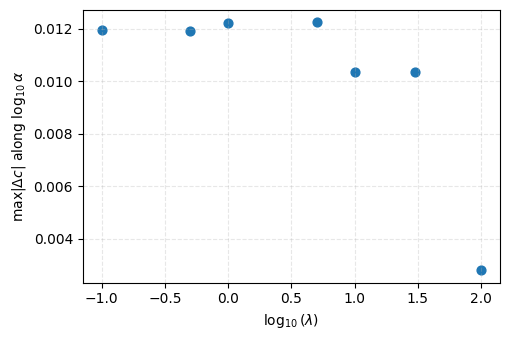

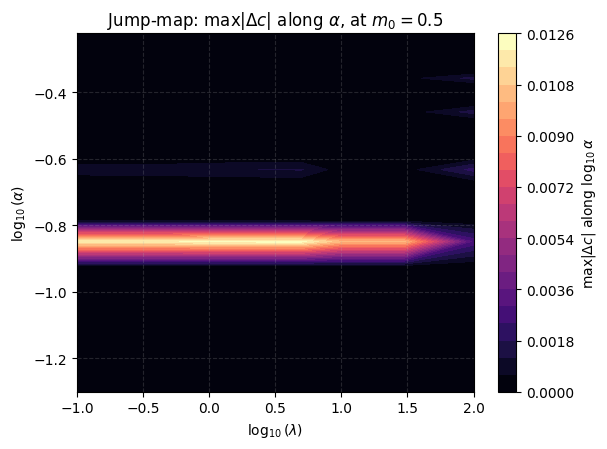

In [ ]:
res = locate_jump_along_alpha(
    base_dirs=("speeds_func_alpha_01",),   # <- only the alpha-specific store
    lambda_vals=[0.1, 0.5, 1, 5, 10, 30, 100],
    alpha_vals=np.linspace(0.05, 0.6, 25),
    m0=0.5,
    which_speed="N",
    verbose=True
)

alpha_star, jump_size = res["alpha_star"], res["jump_size"]
print("alpha_star:", alpha_star)
print("jump_size:",  jump_size)

# quick scatter of jump size vs log10(lambda)
ok = np.isfinite(alpha_star) & np.isfinite(jump_size)
plt.figure(figsize=(5.2,3.5))
plt.scatter(np.log10(np.asarray(res["lambda_vals"])[ok]), jump_size[ok], s=40)
plt.xlabel(r"$\log_{10}(\lambda)$"); plt.ylabel(r"max$|\Delta c|$ along $\log_{10}\alpha$")
plt.grid(True, ls="--", alpha=0.3); plt.tight_layout(); plt.show()

# heatmap view of the jump field
plot_jump_map_alpha(res); plt.show()

In [39]:
# ============================================
# bifurcation_tools.py
# Analyse sharp transitions ("bifurcations")
# in computed wave speeds c(α, λ, m0)
# ============================================

import os, re, json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ----------------------------
# Minimal directory utilities
# ----------------------------
_NUM_PAT = re.compile(r"([0-9eE.\-]+)$")

def _token_variants(v: float):
    v = float(v)
    dec   = f"{v:.12f}".rstrip("0").rstrip(".")
    plain = f"{v:g}"
    sci   = f"{v:.0e}"; s,e = sci.split("e"); sci_neat = f"{s}e{int(e)}"
    toks = {dec, plain, sci, sci_neat}
    toks |= {t.replace(".", "p") for t in list(toks)}  # allow 0p5-style
    return toks

def _exactish_dir(parent: Path, prefix: str, value: float):
    if not parent.exists(): return None
    for tok in _token_variants(value):
        p = parent / f"{prefix}_{tok}"
        if p.is_dir(): return p
    return None

def _closest_dir_by_number(parent: Path, prefix: str, target: float):
    if not parent.exists(): return None
    cands = [d for d in parent.iterdir() if d.is_dir() and d.name.startswith(prefix + "_")]
    if not cands: return None
    def take_num(p: Path):
        m = _NUM_PAT.search(p.name)
        try: return float(m.group(1)) if m else None
        except: return None
    pairs = [(p, take_num(p)) for p in cands]
    pairs = [(p,v) for p,v in pairs if v is not None]
    if not pairs: return None
    return min(pairs, key=lambda pv: abs(pv[1]-float(target)))[0]


def _summary_speed(run_dir: Path, which="N"):
    if run_dir is None: return np.nan
    s = run_dir / "summary.json"
    if not s.exists(): return np.nan
    try:
        meta = json.loads(s.read_text())
        keys = ("speed_N","c_N","wave_speed","speed","c") if str(which).upper()=="N" \
               else ("speed_M","c_M","wave_speed","speed","c")
        for k in keys:
            if k in meta:
                try:
                    v = float(meta[k])
                    if np.isfinite(v): return v
                except: pass
    except: pass
    return np.nan

def _augment_roots(base_dirs):
    """Always return the given roots in order, plus prepend speeds_func_4 if present."""
    if isinstance(base_dirs, (str, os.PathLike)):
        base_dirs = (base_dirs,)
    roots = [str(b) for b in base_dirs]
    if os.path.isdir("speeds_func_4") and "speeds_func_4" not in roots:
        roots = ["speeds_func_4"] + roots
    return tuple(roots)

def _find_dir(base_dirs, lam, alpha, m0):
    """Generic search for run directories: works with speeds_func_alpha_01 too."""
    roots = _augment_roots(base_dirs)
    for root in roots:
        base = Path(root)
        lam_dir = _exactish_dir(base, "lambda", lam) or _closest_dir_by_number(base, "lambda", lam)
        if lam_dir is None: 
            continue
        a_dir = _exactish_dir(lam_dir, "alpha", alpha) or _closest_dir_by_number(lam_dir, "alpha", alpha)
        if a_dir is None: 
            continue
        m_dir = _exactish_dir(a_dir, "m0", m0)
        if m_dir is not None: 
            return m_dir
    return None

# -----------------------------------------
# 1) Locate jump in c along alpha, per λ
# -----------------------------------------
def locate_jump_along_alpha(
    base_dirs,
    lambda_vals,
    alpha_vals,
    m0=0.5,
    which_speed="N",
    verbose=False
):
    lamb = np.asarray(lambda_vals, float)
    alps = np.asarray(alpha_vals,  float)

    C = np.full((len(alps), len(lamb)), np.nan)
    for j, lam in enumerate(lamb):
        for i, a in enumerate(alps):
            d = _find_dir(base_dirs, lam, a, m0)
            C[i, j] = _summary_speed(d, which=which_speed)
        if verbose:
            miss = np.isnan(C[:, j]).sum()
            if miss:
                print(f"[λ={lam:g}] missing α-points: {miss}/{len(alps)}")

    dC = np.abs(np.diff(C, axis=0))  # (A-1, L)
    with np.errstate(all="ignore"):
        idx = np.nanargmax(dC, axis=0)
        jump_size = np.nanmax(dC, axis=0)
    alpha_star = alps[:-1][idx]

    return dict(
        alpha_grid=alps,
        lambda_grid=lamb,
        C=C,
        dC=dC,
        alpha_star=alpha_star,
        jump_size=jump_size
    )

# ---------------------------------------------------
# 2) Transition slices: c(alpha) for several m0, per λ
# ---------------------------------------------------
def plot_transition_slices(
    base_dirs,
    lambda_list,
    alpha_window=(0.1, 0.2),
    m0_list=(0.2, 0.5, 0.9),
    which_speed="N",
    tick_fs=12, label_fs=14, title_fs=16, legend_fs=12
):
    alphas = np.linspace(alpha_window[0], alpha_window[1], 200)
    loga   = np.log10(alphas)

    fig, axes = plt.subplots(1, len(lambda_list), figsize=(5*len(lambda_list), 4), sharey=True)
    if len(lambda_list) == 1: axes = [axes]

    for j, lam in enumerate(lambda_list):
        ax = axes[j]
        for m0 in m0_list:
            cs = []
            for a in alphas:
                d = _find_dir(base_dirs, lam, a, m0)
                cs.append(_summary_speed(d, which=which_speed))
            ax.plot(loga, cs, "-o", ms=3, label=rf"$m_0={m0:g}$")
        ax.set_title(rf"$\lambda={lam:g}$", fontsize=title_fs)
        ax.set_xlabel(r"$\log_{10}(\alpha)$", fontsize=label_fs)
        ax.tick_params(labelsize=tick_fs)
        if j == 0: ax.set_ylabel(r"Wave speed $c$", fontsize=label_fs)
        ax.grid(alpha=0.3)

    axes[-1].legend(fontsize=legend_fs)
    fig.suptitle(r"Dense scan of $c(\alpha)$ around transition region", fontsize=title_fs+2)
    plt.show()
    return fig, axes

# ------------------------------------------
# 3) Hysteresis: α up/down sweep at fixed λ
# ------------------------------------------
def hysteresis_alpha_sweep(
    base_dirs,
    lam,
    alpha_lo=0.1, alpha_hi=0.2,
    m0=0.5,
    n=40,
    which_speed="N",
    tick_fs=12, label_fs=14, title_fs=16, legend_fs=12
):
    alphas_up   = np.linspace(alpha_lo, alpha_hi, n)
    alphas_down = np.linspace(alpha_hi, alpha_lo, n)

    cs_up, cs_down = [], []
    for a in alphas_up:
        d = _find_dir(base_dirs, lam, a, m0)
        cs_up.append(_summary_speed(d, which=which_speed))
    for a in alphas_down:
        d = _find_dir(base_dirs, lam, a, m0)
        cs_down.append(_summary_speed(d, which=which_speed))

    fig, ax = plt.subplots(figsize=(6,4))
    ax.plot(np.log10(alphas_up), cs_up, "-o", ms=4, label="up sweep")
    ax.plot(np.log10(alphas_down), cs_down, "--o", ms=4, label="down sweep")

    ax.set_xlabel(r"$\log_{10}(\alpha)$", fontsize=label_fs)
    ax.set_ylabel(r"Wave speed $c$", fontsize=label_fs)
    ax.set_title(rf"Hysteresis test at $\lambda={lam:g}, m_0={m0:g}$", fontsize=title_fs, fontweight="bold")
    ax.legend(fontsize=legend_fs)
    ax.tick_params(labelsize=tick_fs)
    ax.grid(alpha=0.3)
    plt.show()
    return fig, ax

# -------------------------------------------------------
# 4) Jump heatmap: max |Δc| along α for (λ, α)-rectangles
# -------------------------------------------------------
def plot_jump_heatmap_alpha(
    base_dirs,
    lambda_vals,
    alpha_vals,
    m0=0.5,
    which_speed="N",
    cmap="magma",
    tick_fs=12, label_fs=14, title_fs=16, cbar_fs=12
):
    lamb = np.asarray(lambda_vals, float)
    alps = np.asarray(alpha_vals, float)

    C = np.full((len(alps), len(lamb)), np.nan)
    for j, lam in enumerate(lamb):
        for i, a in enumerate(alps):
            d = _find_dir(base_dirs, lam, a, m0)
            C[i, j] = _summary_speed(d, which=which_speed)

    dC = np.abs(np.diff(C, axis=0))             # (A-1, L)
    X, Y = np.meshgrid(np.log10(lamb), np.log10(alps[:-1]))

    fig, ax = plt.subplots(figsize=(6,5))
    im = ax.contourf(X, Y, dC, levels=40, cmap=cmap)
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label(r"max $|\Delta c|$ along $\log_{10}\alpha$", fontsize=cbar_fs)
    cbar.ax.tick_params(labelsize=cbar_fs)

    ax.set_xlabel(r"$\log_{10}(\lambda)$", fontsize=label_fs)
    ax.set_ylabel(r"$\log_{10}(\alpha)$", fontsize=label_fs)
    ax.set_title(rf"Jump-map: max$|\Delta c|$ along $\alpha$, at $m_0={m0}$",
                 fontsize=title_fs, fontweight="bold")
    ax.tick_params(labelsize=tick_fs)
    ax.grid(alpha=0.2)
    plt.show()

    with np.errstate(all="ignore"):
        max_jump_per_lambda = np.nanmax(dC, axis=0)
    return fig, ax, dict(C=C, dC=dC, max_jump_per_lambda=max_jump_per_lambda)

α* per λ: {np.float64(0.1): np.float64(0.05), np.float64(0.5): np.float64(0.05), np.float64(1.0): np.float64(0.05), np.float64(5.0): np.float64(0.05), np.float64(10.0): np.float64(0.05), np.float64(30.0): np.float64(0.05), np.float64(100.0): np.float64(0.05)}
jump size per λ: {np.float64(0.1): np.float64(0.0), np.float64(0.5): np.float64(0.0), np.float64(1.0): np.float64(0.0), np.float64(5.0): np.float64(0.0), np.float64(10.0): np.float64(0.0), np.float64(30.0): np.float64(0.0), np.float64(100.0): np.float64(0.0)}


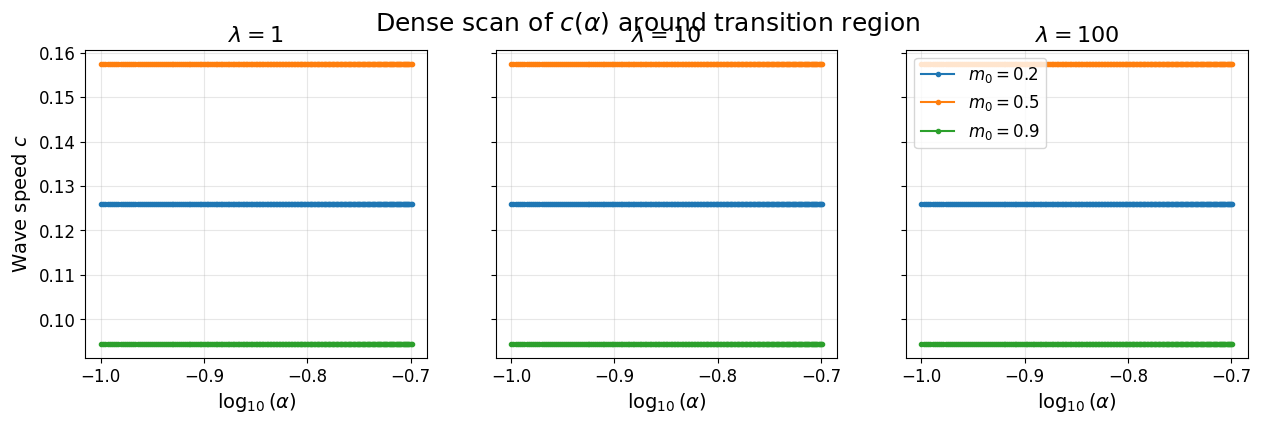

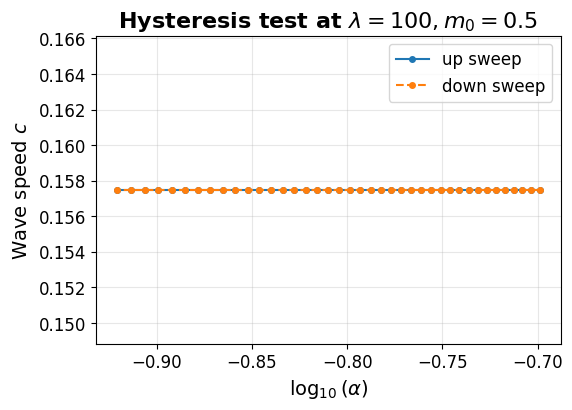

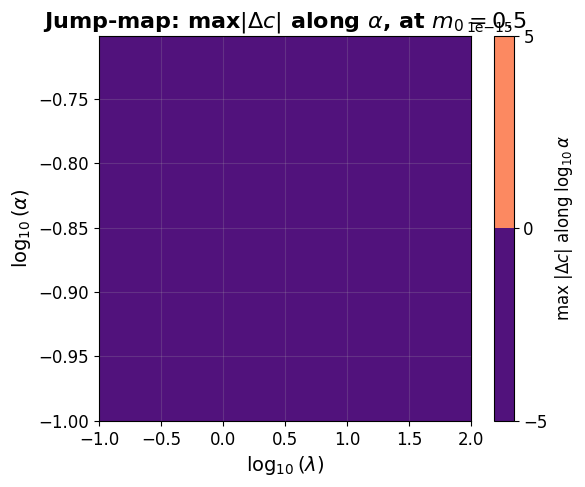

(<Figure size 600x500 with 2 Axes>,
 <Axes: title={'center': 'Jump-map: max$|\\Delta c|$ along $\\alpha$, at $m_0=0.5$'}, xlabel='$\\log_{10}(\\lambda)$', ylabel='$\\log_{10}(\\alpha)$'>,
 {'C': array([[0.15749236, 0.15749236, 0.15749236, ..., 0.15749236, 0.15749236,
          0.15749236],
         [0.15749236, 0.15749236, 0.15749236, ..., 0.15749236, 0.15749236,
          0.15749236],
         [0.15749236, 0.15749236, 0.15749236, ..., 0.15749236, 0.15749236,
          0.15749236],
         ...,
         [0.15749236, 0.15749236, 0.15749236, ..., 0.15749236, 0.15749236,
          0.15749236],
         [0.15749236, 0.15749236, 0.15749236, ..., 0.15749236, 0.15749236,
          0.15749236],
         [0.15749236, 0.15749236, 0.15749236, ..., 0.15749236, 0.15749236,
          0.15749236]], shape=(120, 80)),
  'dC': array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
      

In [40]:
import numpy as np

base_dirs = ("speeds_func_alpha_01",)   # <-- where your α scans are stored

# 1) Locate the biggest α-jump per λ
res = locate_jump_along_alpha(
    base_dirs=base_dirs,
    lambda_vals=[0.1, 0.5, 1, 5, 10, 30, 100],
    alpha_vals=np.linspace(0.05, 0.6, 25),
    m0=0.5,
    verbose=True
)
print("α* per λ:", dict(zip(res["lambda_grid"], res["alpha_star"])))
print("jump size per λ:", dict(zip(res["lambda_grid"], res["jump_size"])))

# 2) Plot c(α) slices around transition window
plot_transition_slices(
    base_dirs=base_dirs,
    lambda_list=[1, 10, 100],
    alpha_window=(0.10, 0.20),
    m0_list=(0.2, 0.5, 0.9)
)

# 3) Hysteresis test
hysteresis_alpha_sweep(
    base_dirs=base_dirs,
    lam=100, alpha_lo=0.12, alpha_hi=0.20, m0=0.5
)

# 4) Jump heatmap
lam_dense  = np.logspace(-1, 2, 80)
alpha_fine = np.linspace(0.10, 0.20, 120)
plot_jump_heatmap_alpha(
    base_dirs=base_dirs,
    lambda_vals=lam_dense,
    alpha_vals=alpha_fine,
    m0=0.5
)

In [41]:
import numpy as np
from pathlib import Path

def _alphas_on_disk_for_lambda(base_dirs, lam, m0):
    """Return sorted α values present on disk under the given λ, m0."""
    alphas = set()
    roots = _augment_roots_by_m0(base_dirs, m0)
    for root in roots:
        lam_dir = _exactish_dir(Path(root), "lambda", lam) or _closest_dir_by_number(Path(root), "lambda", lam)
        if lam_dir is None:
            continue
        for a_dir in lam_dir.iterdir():
            if a_dir.is_dir() and a_dir.name.startswith("alpha_"):
                tok = a_dir.name.split("alpha_", 1)[1].replace("p", ".")
                try: alphas.add(float(tok))
                except: pass
    return np.array(sorted(alphas), float)

def _nearest_on_each_side(values, left, right):
    """Given sorted `values`, return the nearest point ≤left (L) and ≥right (R)."""
    v = np.asarray(values, float)
    if v.size == 0:
        return None, None
    # left side candidate: max value <= left
    Lmask = v <= left
    L = v[Lmask].max() if Lmask.any() else None
    # right side candidate: min value >= right
    Rmask = v >= right
    R = v[Rmask].min() if Rmask.any() else None
    return L, R

In [42]:
def gap_evidence_alpha(base_dirs, lam, m0=0.5, aL=0.1, aR=0.2, which_speed="N", verbose=True):
    """
    For a single λ: find nearest α to the left/right of [aL,aR], read c at both,
    and report the cross-gap change and normalized slope.
    """
    A = _alphas_on_disk_for_lambda(base_dirs, lam, m0)
    L, R = _nearest_on_each_side(A, aL, aR)
    if L is None or R is None:
        if verbose:
            print(f"[λ={lam:g}] Missing endpoint(s) around [{aL},{aR}]. Found α’s: {A.tolist()}")
        return dict(lambda_val=lam, alpha_L=L, alpha_R=R, c_L=np.nan, c_R=np.nan, dc=np.nan, slope_per_decade=np.nan)

    dL = _find_dir(base_dirs, lam, L, m0)
    dR = _find_dir(base_dirs, lam, R, m0)
    cL = _summary_speed(dL, which=which_speed)
    cR = _summary_speed(dR, which=which_speed)

    dc = cR - cL
    # normalize by log10-width to compare different gaps fairly
    width_log = abs(np.log10(R) - np.log10(L)) if (L>0 and R>0) else np.nan
    slope_nd = abs(dc) / width_log if (width_log and np.isfinite(width_log)) else np.nan

    if verbose:
        print(f"[λ={lam:g}] α_L={L:g}, c_L={cL:.5g} | α_R={R:g}, c_R={cR:.5g} | Δc={dc:.5g},  |Δc|/Δlog10α={slope_nd:.5g}")

    return dict(lambda_val=lam, alpha_L=L, alpha_R=R, c_L=cL, c_R=cR, dc=dc, slope_per_decade=slope_nd)

In [43]:
import matplotlib.pyplot as plt

def plot_gap_bracket_alpha(base_dirs, lam, m0=0.5, aL=0.1, aR=0.2, which_speed="N",
                           tick_fs=12, label_fs=14, title_fs=16):
    A = _alphas_on_disk_for_lambda(base_dirs, lam, m0)
    C = []
    for a in A:
        d = _find_dir(base_dirs, lam, a, m0)
        C.append(_summary_speed(d, which=which_speed))
    A = np.asarray(A); C = np.asarray(C)

    fig, ax = plt.subplots(figsize=(6,4))
    if len(A):
        ax.plot(np.log10(A), C, "-o", ms=4)
    # Shade the missing band
    ax.axvspan(np.log10(aL), np.log10(aR), color="tab:gray", alpha=0.15, label="gap [0.1, 0.2]")

    # mark endpoints used in the diagnostic
    L, R = _nearest_on_each_side(A, aL, aR)
    if L is not None:
        dL = _find_dir(base_dirs, lam, L, m0); cL = _summary_speed(dL, which=which_speed)
        ax.plot(np.log10(L), cL, "o", color="tab:red", ms=7, label=rf"left {L:g}")
    if R is not None:
        dR = _find_dir(base_dirs, lam, R, m0); cR = _summary_speed(dR, which=which_speed)
        ax.plot(np.log10(R), cR, "o", color="tab:green", ms=7, label=rf"right {R:g}")

    ax.set_xlabel(r"$\log_{10}(\alpha)$", fontsize=label_fs)
    ax.set_ylabel(r"Wave speed $c$", fontsize=label_fs)
    ax.set_title(rf"$\lambda={lam:g}$, $m_0={m0:g}$ — bracketed gap test", fontsize=title_fs)
    ax.tick_params(labelsize=tick_fs); ax.grid(alpha=0.3)
    ax.legend(fontsize=11)
    plt.show()
    return fig, ax

In [44]:
def scan_gap_across_lambdas(base_dirs, lambda_list, m0=0.5, aL=0.1, aR=0.2, which_speed="N"):
    records = []
    for lam in lambda_list:
        rec = gap_evidence_alpha(base_dirs, lam, m0=m0, aL=aL, aR=aR, which_speed=which_speed, verbose=False)
        records.append(rec)
    # sort by |Δc|/Δlog10α (largest first)
    ranked = sorted(records, key=lambda r: (-np.nan_to_num(r["slope_per_decade"], nan=-1), r["lambda_val"]))
    print("λ  | α_L   α_R   |  Δc      | |Δc|/Δlog10α")
    print("-- | -------------|----------|------------")
    for r in ranked:
        print(f"{r['lambda_val']:>4g} | {r['alpha_L'] if r['alpha_L'] else None!s:>5} {r['alpha_R'] if r['alpha_R'] else None!s:>5} | "
              f"{np.nan if r['dc'] is np.nan else r['dc']:+.5f} | {np.nan if r['slope_per_decade'] is np.nan else r['slope_per_decade']:.5f}")
    return ranked

λ=0.1 -> [1.e-01 2.e-01 3.e-01 4.e-01 5.e-01 1.e+04]
λ=1 -> [1.e-01 2.e-01 3.e-01 4.e-01 5.e-01 1.e+04]
λ=10 -> [1.e-01 2.e-01 3.e-01 4.e-01 5.e-01 1.e+04]
λ=100 -> [1.e-01 2.e-01 3.e-01 4.e-01 5.e-01 1.e+04]
λ=10000 -> [1.e-03 1.e-02 1.e-01 2.e-01 3.e-01 4.e-01 5.e-01 1.e+00 5.e+00 1.e+01
 1.e+02 1.e+03 1.e+04 1.e+05 1.e+06 1.e+07 1.e+08]
λ=1e+08 -> [1.e-01 2.e-01 3.e-01 4.e-01 5.e-01 1.e+04]
[λ=10] α_L=0.1, c_L=0.15749 | α_R=0.2, c_R=0.15749 | Δc=0,  |Δc|/Δlog10α=0


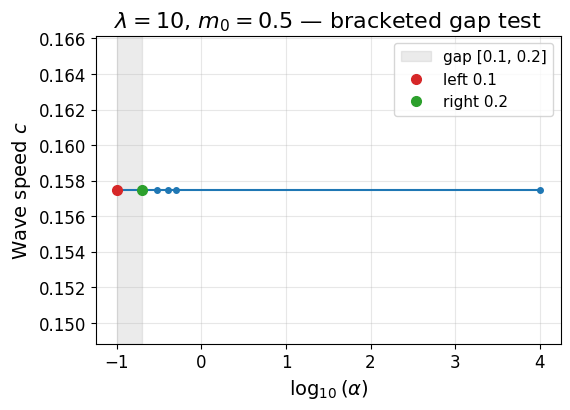

λ  | α_L   α_R   |  Δc      | |Δc|/Δlog10α
-- | -------------|----------|------------
 0.1 |   0.1   0.2 | +0.00000 | 0.00000
 0.5 |   0.1   0.2 | +0.00000 | 0.00000
   1 |   0.1   0.2 | +0.00000 | 0.00000
   5 |   0.1   0.2 | +0.00000 | 0.00000
  10 |   0.1   0.2 | +0.00000 | 0.00000
  30 |   0.1   0.2 | +0.00000 | 0.00000
 100 |   0.1   0.2 | +0.00000 | 0.00000
10000 |   0.1   0.2 | +0.00000 | 0.00000
1e+08 |   0.1   0.2 | +0.00000 | 0.00000


In [45]:
base_dirs = ("speeds_func_alpha_01",)   # <- your new run folder
m0 = 0.5
gap = (0.1, 0.2)

# 1) See what α exist already for a few λ
for lam in (0.1, 1, 10, 100, 1e4, 1e8):
    print(f"λ={lam:g} ->", _alphas_on_disk_for_lambda(base_dirs, lam, m0))

# 2) For a λ you care about, print the gap diagnostic and draw the bracket plot
rec = gap_evidence_alpha(base_dirs, lam=10, m0=m0, aL=gap[0], aR=gap[1], which_speed="N", verbose=True)
plot_gap_bracket_alpha(base_dirs, lam=10, m0=m0, aL=gap[0], aR=gap[1], which_speed="N")

# 3) Rank λ’s by how “suspicious” the missing band looks
ranked = scan_gap_across_lambdas(base_dirs, lambda_list=[0.1, 0.5, 1, 5, 10, 30, 100, 1e4, 1e8],
                                 m0=m0, aL=gap[0], aR=gap[1], which_speed="N")

In [54]:
import numpy as np
import matplotlib.pyplot as plt

def bracketed_gap_test(
    base_dirs,
    lambda_list,
    alpha_left=0.1,
    alpha_right=0.2,
    m0=0.5,
    which_speed="N",
    make_plot=True,
    tick_fs=12, label_fs=14, title_fs=16, legend_fs=12
):
    """
    Check the jump in wave speed across the bracket [alpha_left, alpha_right]
    for several lambdas, using only the two endpoints you have already.

    Returns a dict with arrays:
      'lambda', 'c_left', 'c_right', 'delta_c', 'delta_per_dloga'
    """
    lams = np.asarray(lambda_list, float)
    cL   = np.full_like(lams, np.nan, dtype=float)
    cR   = np.full_like(lams, np.nan, dtype=float)

    for j, lam in enumerate(lams):
        dL = _find_dir(base_dirs, lam, alpha_left,  m0)
        dR = _find_dir(base_dirs, lam, alpha_right, m0)
        cL[j] = _summary_speed(dL, which=which_speed)
        cR[j] = _summary_speed(dR, which=which_speed)

    dloga = np.log10(alpha_right) - np.log10(alpha_left)
    delta_c = cR - cL
    with np.errstate(invalid="ignore", divide="ignore"):
        delta_per_dloga = delta_c / dloga

    # ---- pretty print table ----
    print(". λ  | α_L   α_R   |  Δc      | |Δc|/Δlog10α")
    print("-- | -------------|----------|------------")
    for lam, d in zip(lams, delta_c):
        s = "nan" if not np.isfinite(d) else f"{d:+.5f}"
        s2 = "nan" if not np.isfinite(d) else f"{abs(d)/dloga:.5f}"
        print(f"{lam:>4g} | {alpha_left:6g} {alpha_right:6g} | {s:>8} | {s2:>10}")

    # ---- optional simple figure for one representative λ ----
    if make_plot and len(lams) == 1:
        lam = float(lams[0])
        fig, ax = plt.subplots(figsize=(5.2, 3.6))
        # draw a flat line at c_left across a wide x range, to see the bracket
        xs = np.array([1e-4, 1e4])
        ax.plot(np.log10(xs), np.full_like(xs, cL[0]), "-", lw=1.5, alpha=0.6)
        ax.scatter([np.log10(alpha_left)],  [cL[0]], color="tab:red",   label=f"left {alpha_left:g}")
        ax.scatter([np.log10(alpha_right)], [cR[0]], color="tab:green", label=f"right {alpha_right:g}")
        ax.axvspan(np.log10(alpha_left), np.log10(alpha_right), color="k", alpha=0.08, label=f"gap [{alpha_left:g}, {alpha_right:g}]")

        ax.set_xlabel(r"$\log_{10}(\alpha)$", fontsize=label_fs)
        ax.set_ylabel(r"Wave speed $c$", fontsize=label_fs)
        ax.set_title(rf"$\lambda={lam:g},\ m_0={m0:g}$ — bracketed gap test", fontsize=title_fs)
        ax.legend(fontsize=legend_fs); ax.grid(alpha=0.3); ax.tick_params(labelsize=tick_fs)
        plt.tight_layout()

    return {
        "lambda": lams,
        "c_left": cL,
        "c_right": cR,
        "delta_c": delta_c,
        "delta_per_dloga": delta_per_dloga,
        "alpha_left": float(alpha_left),
        "alpha_right": float(alpha_right),
        "m0": float(m0),
    }

In [55]:
res = bracketed_gap_test(
    base_dirs=("speeds_func_alpha_01",),   # only your α-scan store
    lambda_list=[0.1, 0.5, 1, 5, 10, 30, 100, 1e4],
    alpha_left=0.1, alpha_right=0.2,
    m0=0.5, which_speed="N"
)

. λ  | α_L   α_R   |  Δc      | |Δc|/Δlog10α
-- | -------------|----------|------------
 0.1 |    0.1    0.2 | +0.00000 |    0.00000
 0.5 |    0.1    0.2 | +0.00000 |    0.00000
   1 |    0.1    0.2 | +0.00000 |    0.00000
   5 |    0.1    0.2 | +0.00000 |    0.00000
  10 |    0.1    0.2 | +0.00000 |    0.00000
  30 |    0.1    0.2 | +0.00000 |    0.00000
 100 |    0.1    0.2 | +0.00000 |    0.00000
10000 |    0.1    0.2 | +0.00000 |    0.00000


In [47]:
res = locate_jump_along_alpha(
    base_dirs=("speeds_func_alpha_01",),
    lambda_vals=[0.1, 0.5, 1, 5, 10, 30, 100, 1e4],
    alpha_vals=[0.1, 0.2, 0.3, 0.4, 0.5],
    m0=0.5, which_speed="N", verbose=True
)
# res["alpha_star"] and res["jump_size"] will highlight that the max jump happens at the (0.1,0.2) edge.

In [48]:
res["alpha_star"]

array([0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.3])

In [50]:
res["jump_size"]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.00962339])

In [51]:
import numpy as np
import matplotlib.pyplot as plt

def adaptive_alpha_refine(base_dirs, lam, m0, aL=0.1, aR=0.2, which_speed="N",
                          max_iter=6, pts_per_iter=3, tol=5e-4,
                          tick_fs=12, label_fs=14, title_fs=16):
    """
    Iteratively sample c(alpha) in [aL,aR] around the suspected jump.
    Keeps all samples; stops when max |Δc| between neighbors stops changing significantly.
    """
    S = {aL: None, aR: None}  # alpha -> c
    def c_at(a):
        if a in S and S[a] is not None: return S[a]
        d = _find_dir(base_dirs, lam, a, m0)
        S[a] = _summary_speed(d, which=which_speed)
        return S[a]

    # seed
    c_at(aL); c_at(aR)

    for _ in range(max_iter):
        alphas = sorted(S.keys())
        cs     = np.array([S[a] for a in alphas], float)
        # find interval with largest jump
        diffs = np.abs(np.diff(cs))
        if np.all(~np.isfinite(diffs)):
            break
        k = np.nanargmax(diffs)
        a_lo, a_hi = alphas[k], alphas[k+1]
        # put interior points (midpoints)
        new_as = np.linspace(a_lo, a_hi, pts_per_iter+2)[1:-1]
        for a in new_as: c_at(float(a))
        # convergence check
        alphas2 = sorted(S.keys())
        cs2     = np.array([S[a] for a in alphas2], float)
        if np.nanmax(np.abs(np.diff(cs2))) - np.nanmax(diffs) < tol:
            break

    # plot
    alphas = np.array(sorted(S.keys()))
    cs     = np.array([S[a] for a in alphas], float)
    fig, ax = plt.subplots(figsize=(5.2,3.6))
    ax.plot(np.log10(alphas), cs, "-o", ms=5)
    ax.axvline(np.log10(aL), color="k", lw=1, alpha=.2)
    ax.axvline(np.log10(aR), color="k", lw=1, alpha=.2)
    ax.set_xlabel(r"$\log_{10}(\alpha)$", fontsize=label_fs)
    ax.set_ylabel(r"Wave speed $c$", fontsize=label_fs)
    ax.set_title(rf"Adaptive zoom: $\lambda={lam:g}$, $m_0={m0:g}$ in $[{aL},{aR}]$", fontsize=title_fs)
    ax.grid(alpha=.3); ax.tick_params(labelsize=tick_fs)
    plt.tight_layout()
    return {"alphas": alphas, "c": cs, "max_jump": float(np.nanmax(np.abs(np.diff(cs))))}

max |Δc| in window: 0.0


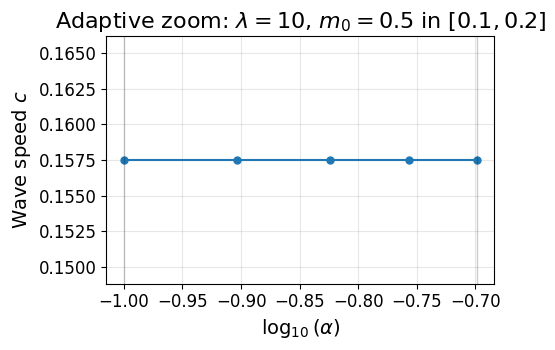

In [52]:
zoom = adaptive_alpha_refine(
    base_dirs=("speeds_func_alpha_01",),
    lam=10, m0=0.5, aL=0.1, aR=0.2, which_speed="N",
    max_iter=6, pts_per_iter=3
)
print("max |Δc| in window:", zoom["max_jump"])

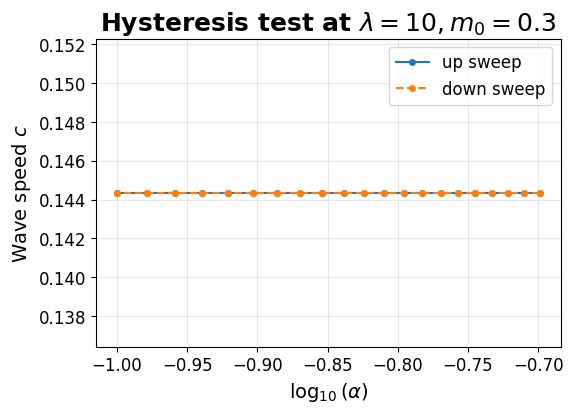

(<Figure size 600x400 with 1 Axes>,
 <Axes: title={'center': 'Hysteresis test at $\\lambda=10, m_0=0.3$'}, xlabel='$\\log_{10}(\\alpha)$', ylabel='Wave speed $c$'>)

In [56]:
hysteresis_alpha_sweep(
    base_dirs=("speeds_func_alpha_01",),
    lam=10, m0=0.3, which_speed="N",
    alpha_lo=0.1, alpha_hi=0.2, n=21,    # when new α are available this draws the loop
    tick_fs=12, label_fs=14, title_fs=18, legend_fs=12
)

In [59]:
# -------- Minimal helpers to locate runs and read measured c --------
import os, re, json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.ticker import MaxNLocator
from scipy.integrate import solve_ivp

_NUM_PAT = re.compile(r"([0-9eE.\-]+)$")

def _token_variants(v: float):
    v = float(v)
    dec   = f"{v:.12f}".rstrip("0").rstrip(".")
    plain = f"{v:g}"
    sci   = f"{v:.0e}"; s,e = sci.split("e"); sci_neat = f"{s}e{int(e)}"
    toks = {dec, plain, sci, sci_neat}
    toks |= {t.replace(".", "p") for t in list(toks)}  # allow 0p5-style tokens
    return toks

def _exactish_dir(parent: Path, prefix: str, value: float):
    if not parent.exists(): return None
    for tok in _token_variants(value):
        p = parent / f"{prefix}_{tok}"
        if p.is_dir(): return p
    return None

def _closest_dir_by_number(parent: Path, prefix: str, target: float):
    if not parent.exists(): return None
    cands = [d for d in parent.iterdir() if d.is_dir() and d.name.startswith(prefix + "_")]
    if not cands: return None
    def take_num(p: Path):
        m = _NUM_PAT.search(p.name)
        try: return float(m.group(1)) if m else None
        except: return None
    pairs = [(p, take_num(p)) for p in cands]
    pairs = [(p,v) for p,v in pairs if v is not None]
    if not pairs: return None
    return min(pairs, key=lambda pv: abs(pv[1]-float(target)))[0]

def _augment_roots_by_m0(base_dirs, m0: float):
    """Prefer patch folder then correct family (u if m0≥.5 else l)."""
    if isinstance(base_dirs, (str, os.PathLike)): base_dirs = (base_dirs,)
    roots = [str(b) for b in base_dirs]
    if os.path.isdir("speeds_func_4"):
        roots = ["speeds_func_4"] + roots
    want  = "speeds_func_u" if float(m0) >= 0.5 else "speeds_func_l"
    other = "speeds_func_l" if want == "speeds_func_u" else "speeds_func_u"
    ordered = [r for r in (want, other) if r in roots] + [r for r in roots if r not in (want, other)]
    seen, out = set(), []
    for r in ordered:
        if r not in seen: seen.add(r); out.append(r)
    return tuple(out)

def _find_dir(base_dirs, lam, alpha, m0):
    """Return Path to .../lambda_*/alpha_*/m0_* using exactish tokens (λ,α nearest allowed; m0 must match)."""
    roots = _augment_roots_by_m0(base_dirs, m0)
    for root in roots:
        base = Path(root)
        lam_dir = _exactish_dir(base, "lambda", lam) or _closest_dir_by_number(base, "lambda", lam)
        if lam_dir is None: continue
        a_dir = _exactish_dir(lam_dir, "alpha", alpha) or _closest_dir_by_number(lam_dir, "alpha", alpha)
        if a_dir is None: continue
        m_dir = _exactish_dir(a_dir, "m0", m0)   # m0 must be exactish
        if m_dir is not None: return m_dir
    return None

def _summary_speed(run_dir: Path, which="N"):
    """Read measured speed from summary.json (tries speed_N/c_N/wave_speed/speed/c)."""
    if run_dir is None: return np.nan
    s = Path(run_dir) / "summary.json"
    if not s.exists(): return np.nan
    try:
        meta = json.loads(s.read_text())
        keys = ("speed_N","c_N","wave_speed","speed","c") if str(which).upper()=="N" \
               else ("speed_M","c_M","wave_speed","speed","c")
        for k in keys:
            if k in meta:
                try:
                    v = float(meta[k])
                    if np.isfinite(v): return v
                except: pass
    except: pass
    return np.nan

def get_measured_c(base_dirs, lam, alpha, m0, which="N"):
    d = _find_dir(base_dirs, lam, alpha, m0)
    return _summary_speed(d, which=which)

# ---------------- ODE system + guard ----------------
def rhs_design(z, X, c, lam, alpha):
    U, P, M = X
    D = M*(1.0 - M)
    dU = P
    dP = -c*P - U*(1.0 - U)*D
    dM = (D/c)*(lam*U*M - alpha*(1.0 - M))
    return [dU, dP, dM]

def make_stop_event_generic(blowU=5.0, blowP=5.0):
    """Stop if M leaves [0,1] (with small slack) or |U|,|P| blow up."""
    def event(t, X, *args):
        U, P, M = X
        badM   = (M < -1e-6) or (M > 1.0 + 1e-6)
        blowUP = (not np.isfinite(U)) or (not np.isfinite(P)) or (abs(U)>blowU) or (abs(P)>blowP)
        return 0.0 if (badM or blowUP) else 1.0
    event.terminal  = True
    event.direction = 0
    return event

# ------------- Refactored phase-plane plotter -------------
def plot_phaseplane_recovery_hero_with_profiles(
    *, lam, alpha, m0,
    U0=0.99, P0=-0.001, M0=None,
    speeds=None,                # list of c's; if None we’ll look up measured c and build [0.8c, c, 1.2c]
    base_dirs=("speeds_func_alpha_01",),  # where to read measured c from
    which_speed="N",
    z_end=400.0, dz=0.01,
    rtol=1e-12, atol=1e-14, max_step=0.01
):
    # If no speeds provided, fetch measured c and build a small band around it
    if speeds is None:
        c_meas = get_measured_c(base_dirs, lam, alpha, m0, which=which_speed)
        if not np.isfinite(c_meas):
            raise RuntimeError(f"No measured speed found for λ={lam:g}, α={alpha:g}, m0={m0:g}")
        speeds = [max(1e-8, 0.8*c_meas), c_meas, 1.2*c_meas]
        c_ref  = c_meas
    else:
        # still try to get c_meas for labeling; if missing, use middle speed as ref
        c_meas = get_measured_c(base_dirs, lam, alpha, m0, which=which_speed)
        c_ref  = speeds[len(speeds)//2] if not np.isfinite(c_meas) else c_meas

    if M0 is None:
        M0 = m0

    t_eval = np.arange(0.0, z_end+dz, dz)
    guard_evt = make_stop_event_generic()

    sols = []
    for c in speeds:
        sol = solve_ivp(
            rhs_design, (0.0, z_end), [U0, P0, M0],
            args=(c, lam, alpha),
            method="BDF", rtol=rtol, atol=atol, max_step=max_step,
            t_eval=t_eval, events=guard_evt
        )
        sols.append((c, sol))

    def rel_lab(c, cref, eps=1e-12):
        if c < cref - eps: return r"$c<c_{\rm meas}$"
        if abs(c - cref) <= eps: return r"$c=c_{\rm meas}$"
        return r"$c>c_{\rm meas}$"

    # ----------------- Layout -----------------
    fig = plt.figure(figsize=(12.5, 7.6))
    gs  = GridSpec(2, 2, height_ratios=[2.2, 1.4], hspace=0.35, wspace=0.28)

    # Top: big U–P
    ax_up = fig.add_subplot(gs[0, :])
    colors = ["tab:blue", "purple", "tab:orange", "tab:green", "tab:red"]
    lines  = []

    for (c, sol), col in zip(sols, colors):
        U, P = sol.y[0], sol.y[1]
        ln, = ax_up.plot(U, P, lw=2.6, color=col, label=rel_lab(c, c_ref))
        ax_up.plot(U[0],  P[0],  marker='o', ms=6, mfc='none', mec=col)
        ax_up.plot(U[-1], P[-1], marker='o', ms=6, mfc=col,   mec=col)
        lines.append(ln)

    ax_up.axhline(0, ls='--', lw=1.4, color='0.5')
    ax_up.axvline(0, ls='--', lw=1.2, color='0.7')
    ax_up.grid(True, ls=':', alpha=0.7)
    ax_up.set_xlabel("U", fontsize=15)
    ax_up.set_ylabel("P", fontsize=15)
    ax_up.tick_params(labelsize=13)
    ax_up.set_title("U vs P", pad=12, fontsize=15)

    # Bottom-left: U vs ξ
    ax_U = fig.add_subplot(gs[1, 0])
    for (c, sol), col in zip(sols, colors):
        ax_U.plot(sol.t, sol.y[0], color=col, lw=2.0)
    ax_U.grid(True, ls=':', alpha=0.7)
    ax_U.set_xlabel(r"$\xi$", fontsize=14)
    ax_U.set_ylabel("U", fontsize=14)
    ax_U.tick_params(labelsize=12)
    ax_U.yaxis.set_major_locator(MaxNLocator(nbins=6))

    # Bottom-right: M vs ξ
    ax_M = fig.add_subplot(gs[1, 1], sharex=ax_U)
    for (c, sol), col in zip(sols, colors):
        ax_M.plot(sol.t, sol.y[2], color=col, lw=2.0)
    ax_M.grid(True, ls=':', alpha=0.7)
    ax_M.set_xlabel(r"$\xi$", fontsize=14)
    ax_M.set_ylabel("M", fontsize=14)
    ax_M.tick_params(labelsize=12)
    ax_M.yaxis.set_major_locator(MaxNLocator(nbins=6))

    # Shared legend on the RIGHT
    fig.legend(lines, [ln.get_label() for ln in lines],
               loc="center left", bbox_to_anchor=(.9, 0.5),
               frameon=False, fontsize=15)

    # Title + subtitle
    subtitle = rf"$\alpha={alpha:g}, \ \lambda={lam:g}, \ m_0={m0:.2f}, \ c_{{\rm meas}}={c_ref:.4g}$"
    fig.suptitle("Phase plane plot: Recovery", y=1.02, fontsize=20, weight='bold')
    plt.figtext(0.5, 0.95, subtitle, ha="center", fontsize=14)

    # leave space on the right for the legend
    plt.tight_layout(rect=[0.02, 0.04, 0.86, 0.94])
    plt.show()

    return {"c_meas": c_ref, "speeds": speeds, "solutions": [s for _, s in sols]}

# ---------------- Convenience wrapper ----------------
def run_phase_plane_from_results(
    base_dirs, lam, alpha, m0=0.5, which="N", widen=0.2,
    U0=0.99, P0=-0.001, M0=None, z_end=600.0
):
    """Fetch measured c and plot three trajectories: [0.8c, c, 1.2c]."""
    c_meas = get_measured_c(base_dirs, lam, alpha, m0, which)
    if not np.isfinite(c_meas):
        print(f"[warn] no measured speed for λ={lam:g}, α={alpha:g}, m0={m0:g}")
        return None
    speeds = [max(1e-8, (1.0 - widen)*c_meas), c_meas, (1.0 + widen)*c_meas]

    # choose M0 near α/(α+λ), nudged up a bit
    if M0 is None:
        mbar = alpha/(alpha+lam)
        M0   = min(1.0 - 1e-9, mbar + 0.01)

    return plot_phaseplane_recovery_hero_with_profiles(
        lam=lam, alpha=alpha, m0=m0,
        U0=U0, P0=P0, M0=M0,
        speeds=speeds,
        base_dirs=base_dirs, which_speed=which,
        z_end=z_end, dz=0.01, rtol=1e-12, atol=1e-14, max_step=0.01
    )

/var/folders/db/nfyhgnf50fxd8qjfrpdb671c0000gn/T/ipykernel_69637/2198419050.py:208: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0.02, 0.04, 0.86, 0.94])


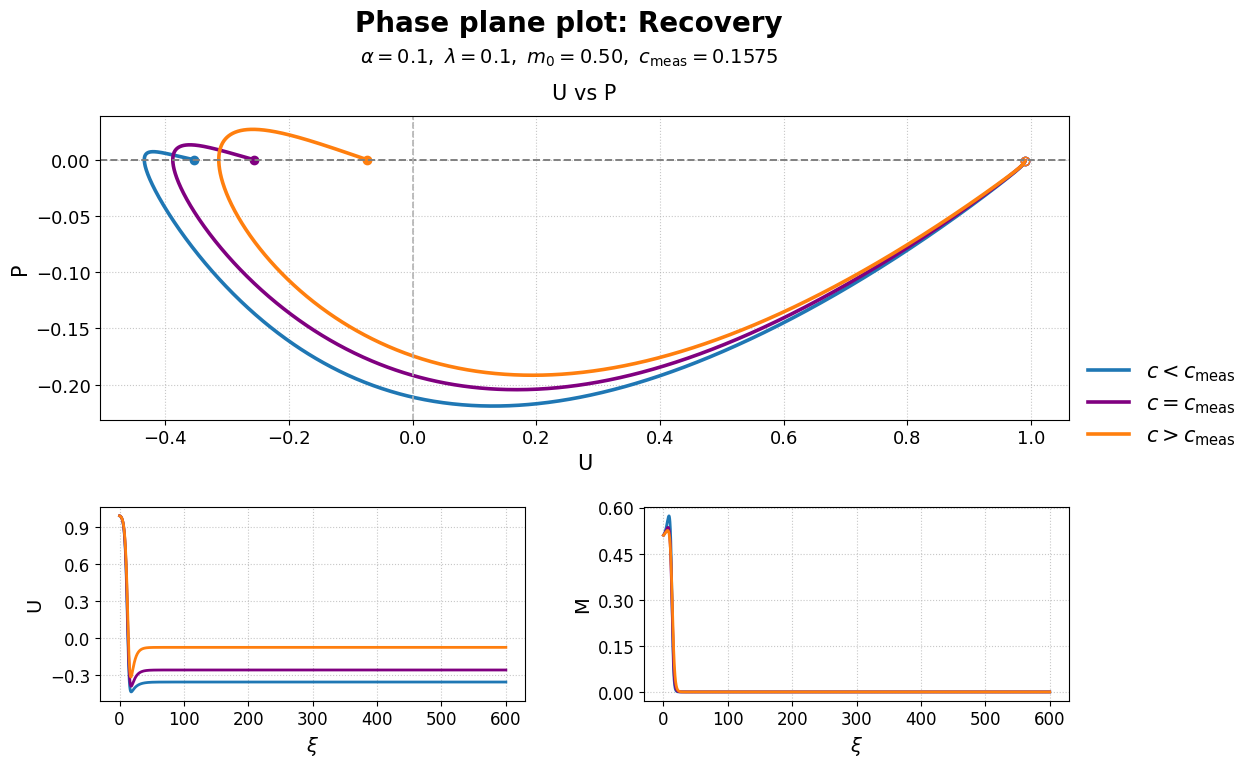

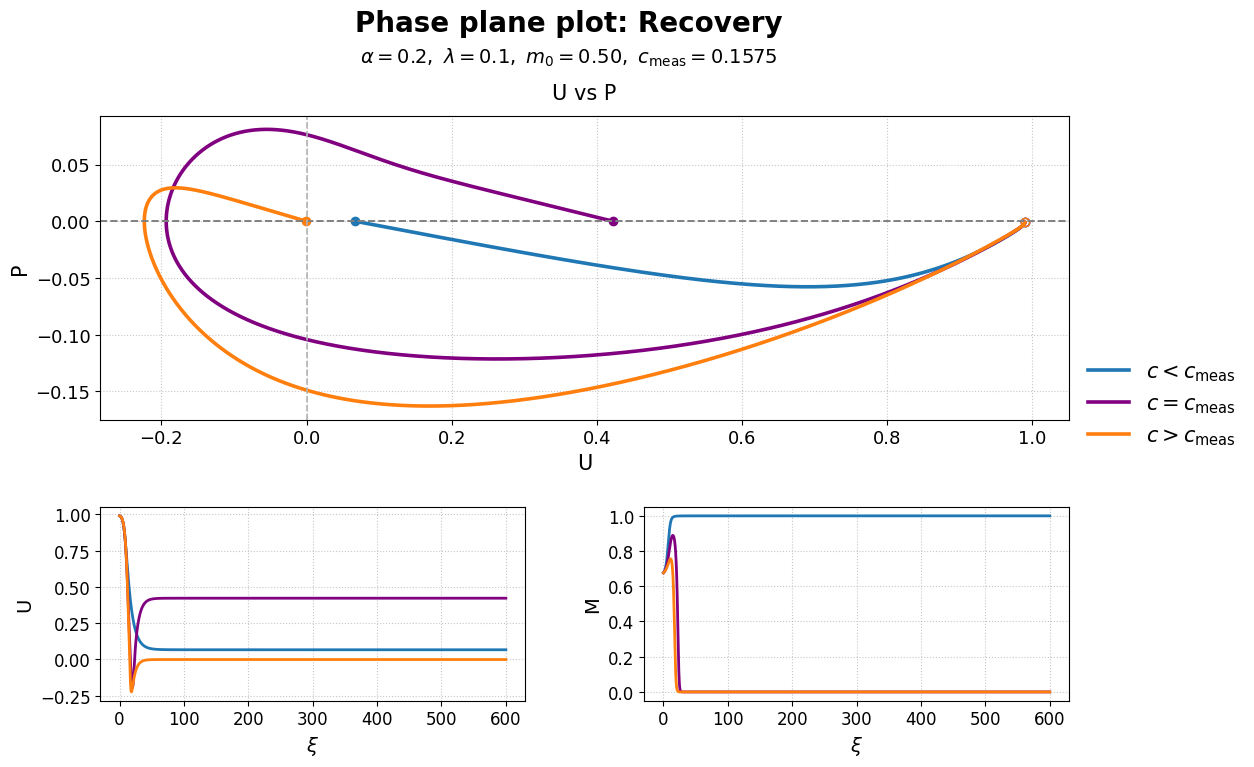

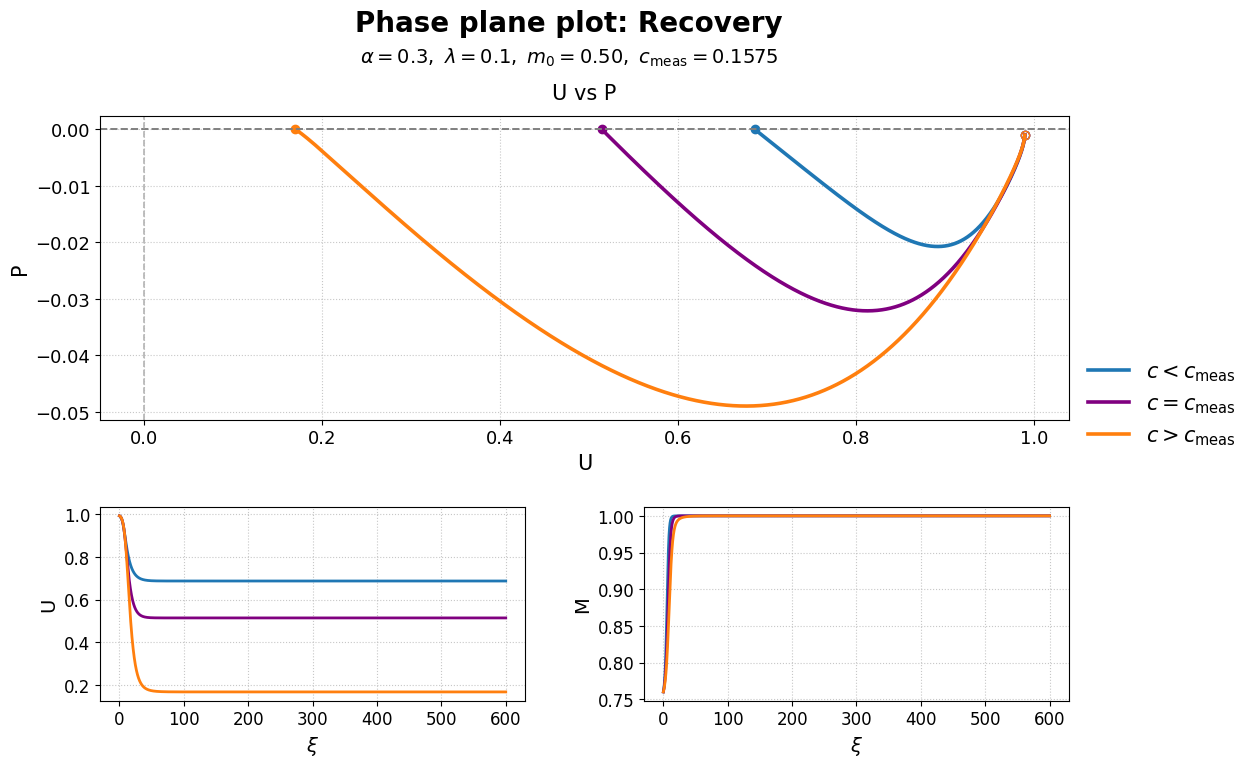

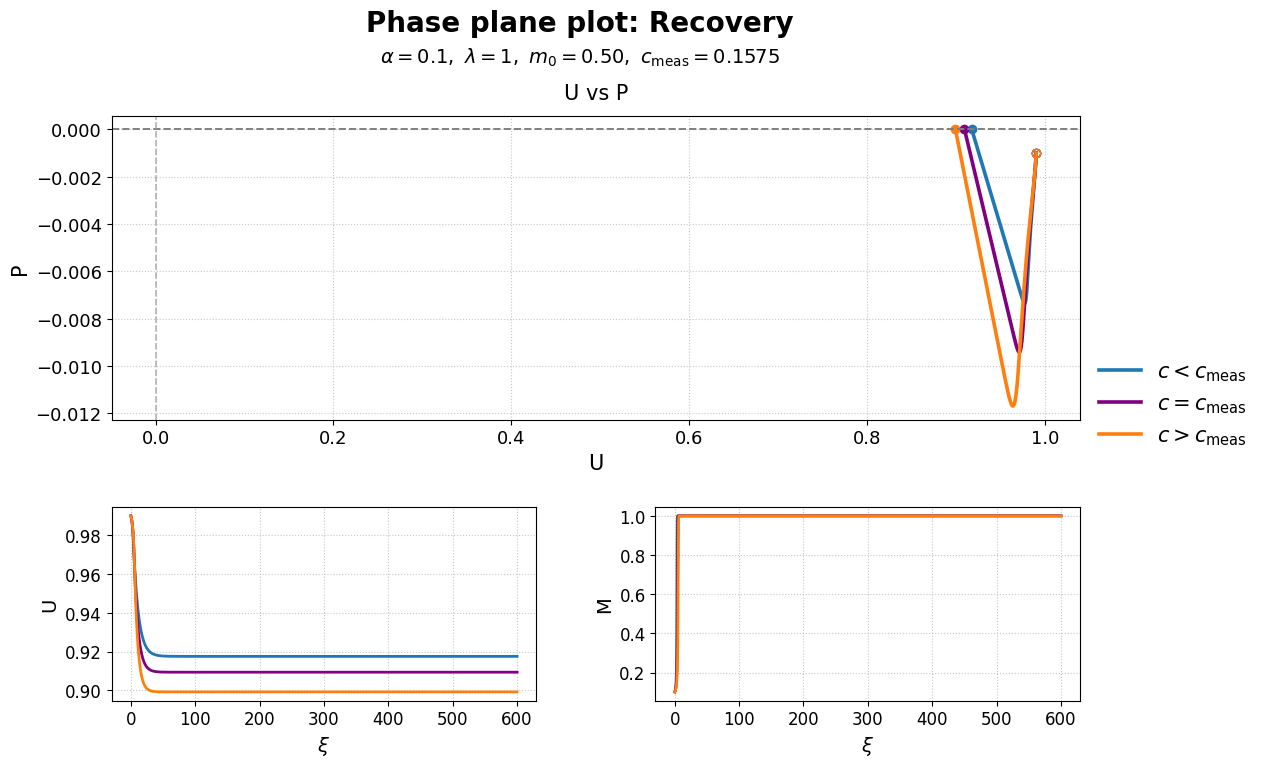

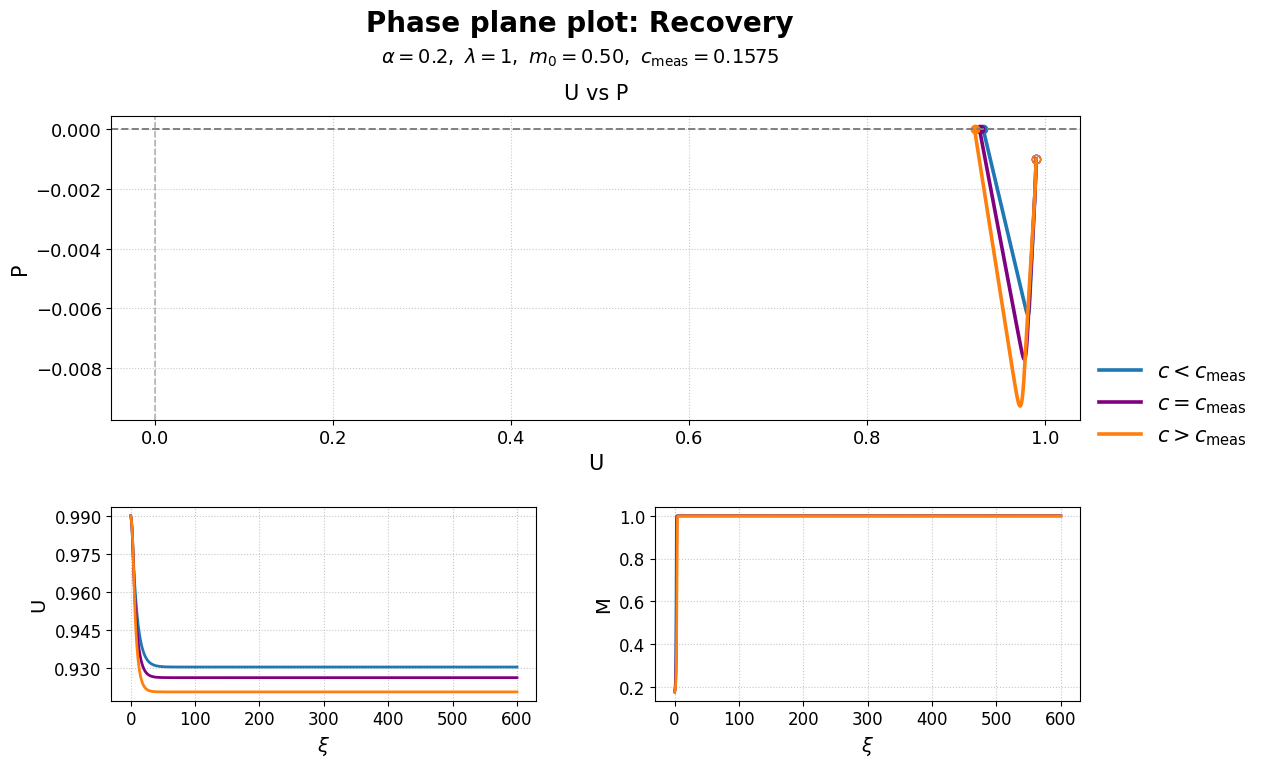

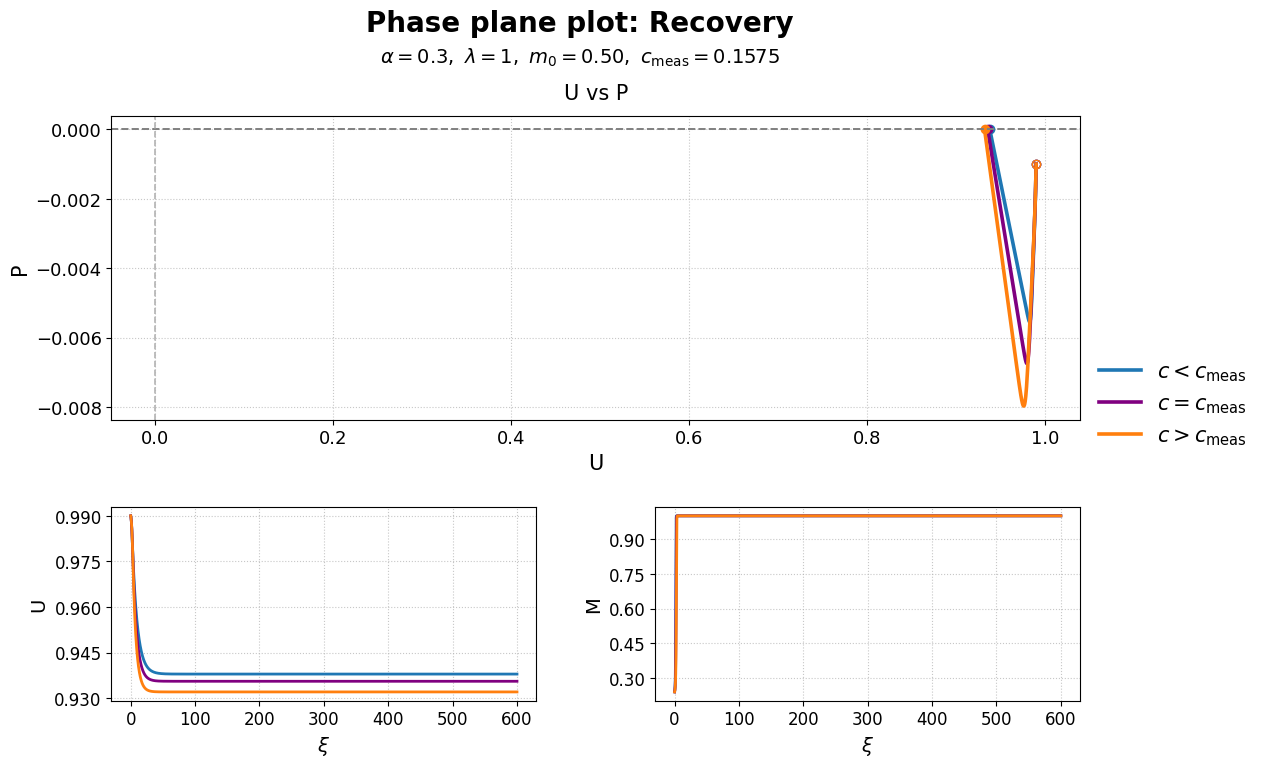

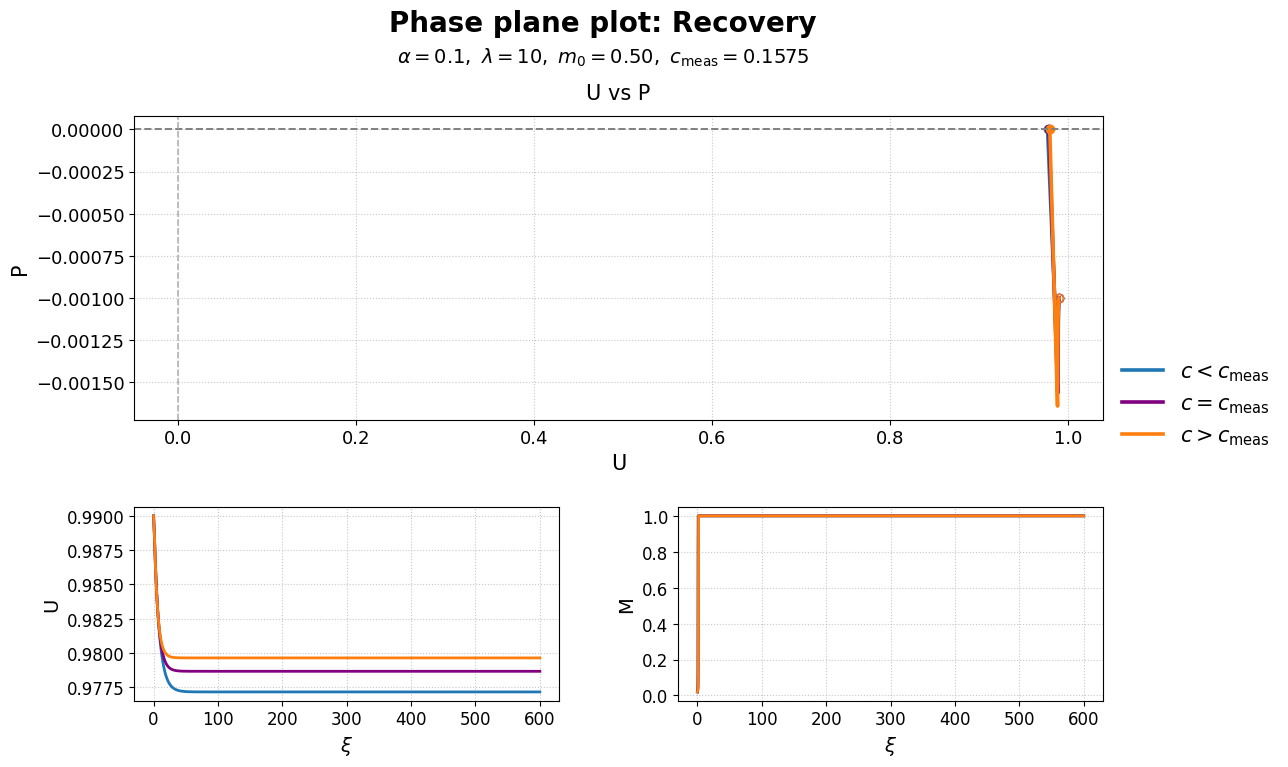

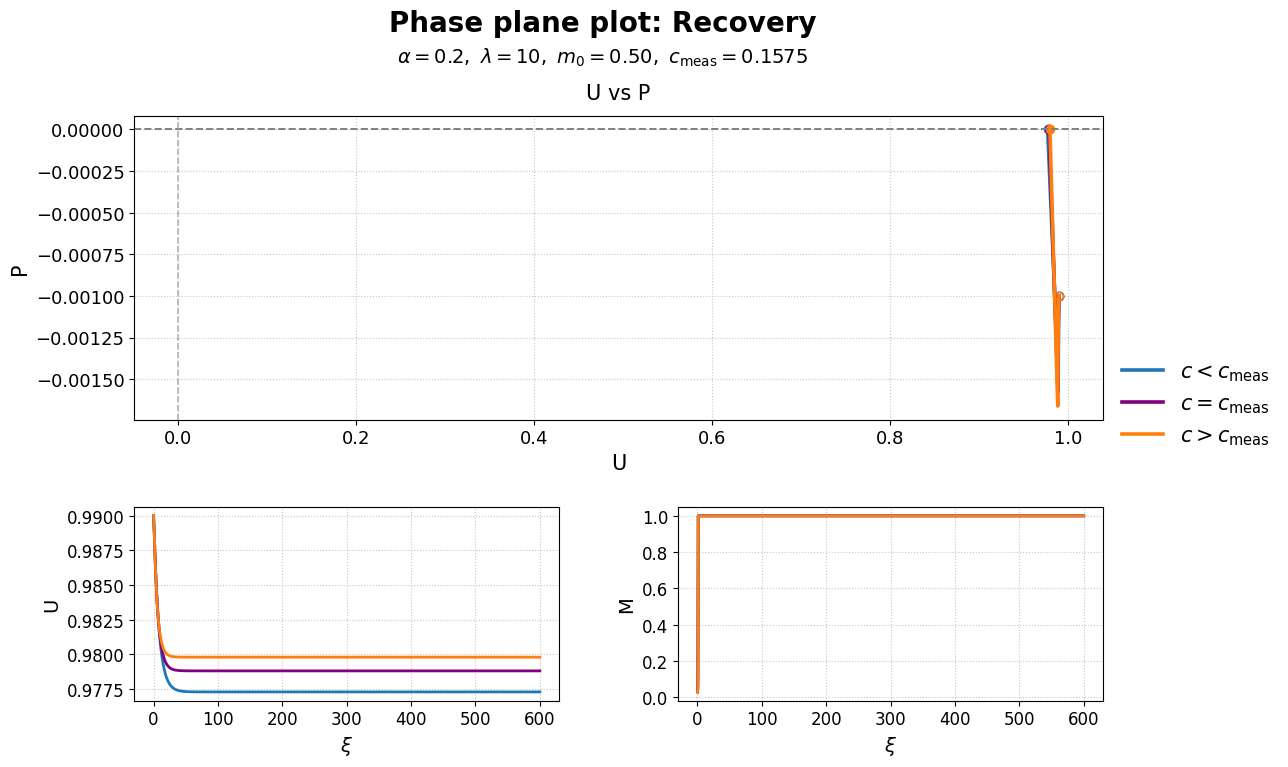

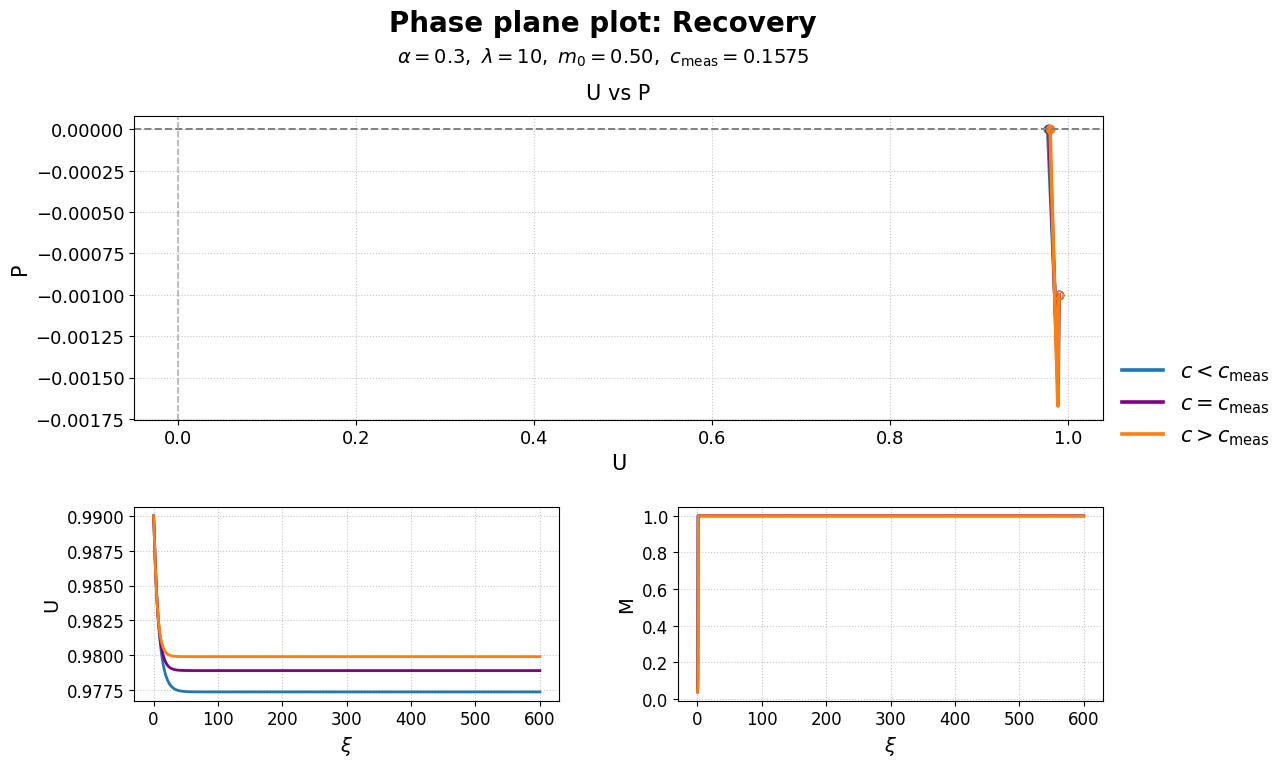

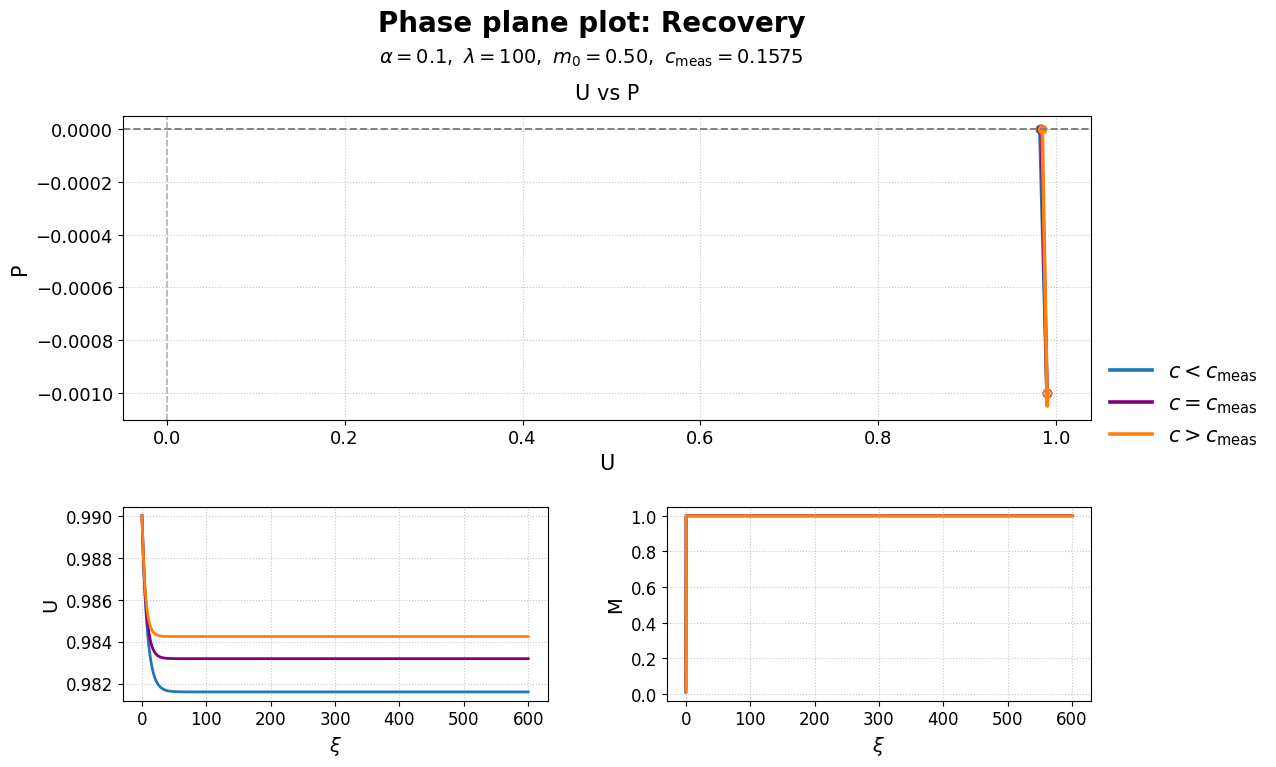

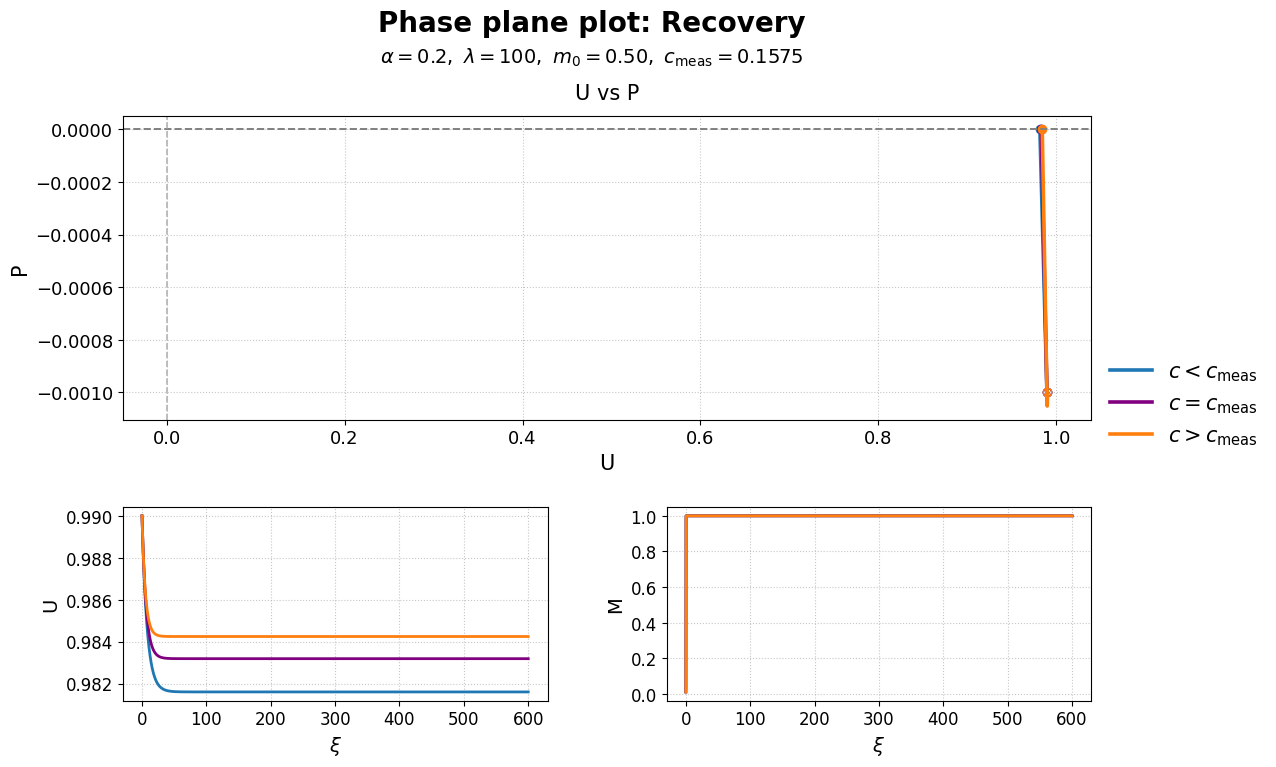

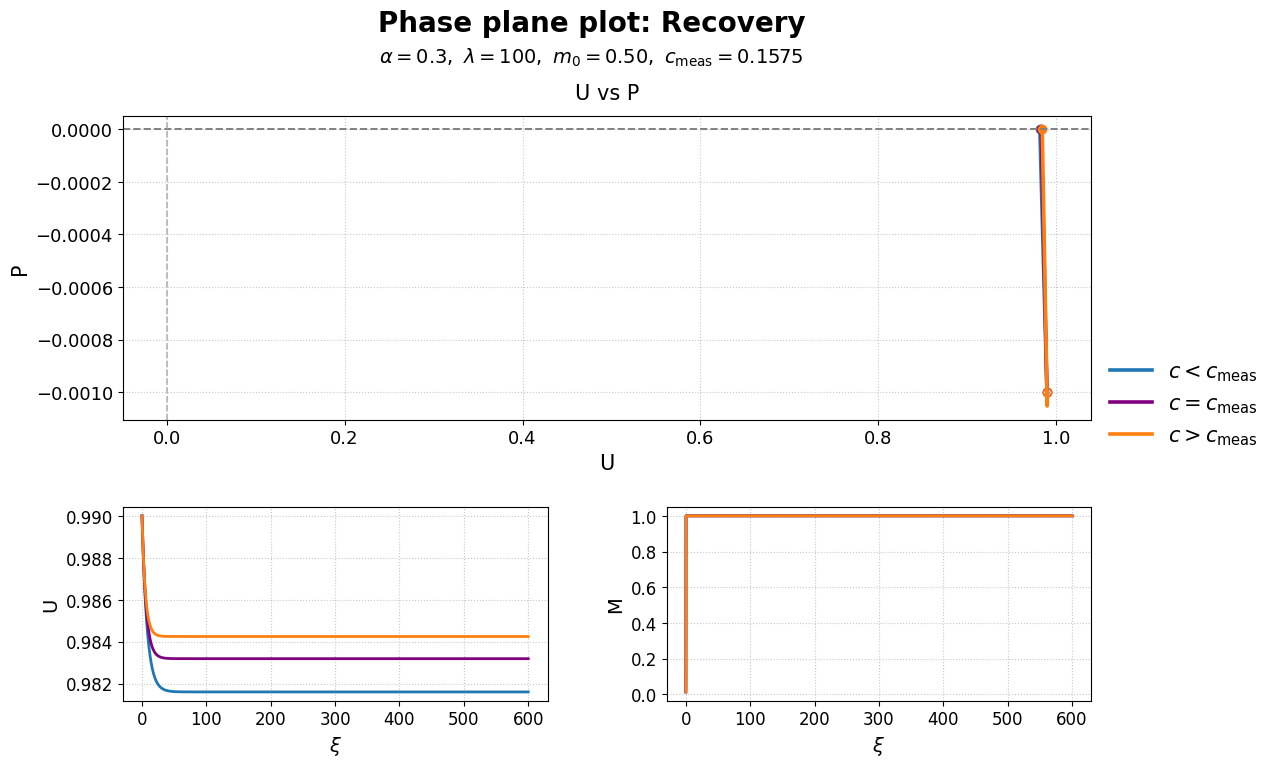

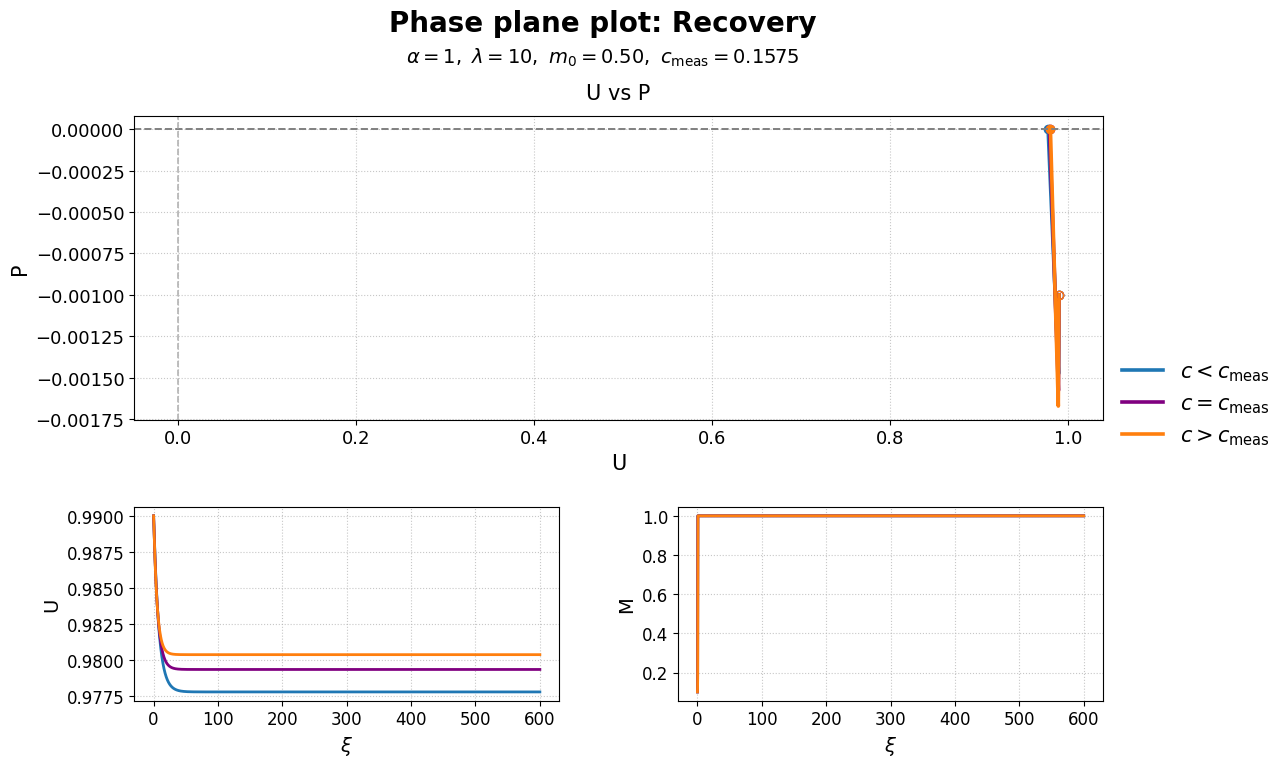

{'c_meas': 0.15749235754098023,
 'speeds': [0.1259938860327842, 0.15749235754098023, 0.18899082904917627],
 'solutions': [  message: The solver successfully reached the end of the integration interval.
    success: True
     status: 0
          t: [ 0.000e+00  1.000e-02 ...  6.000e+02  6.000e+02]
          y: [[ 9.900e-01  9.900e-01 ...  9.778e-01  9.778e-01]
              [-1.000e-03 -1.008e-03 ... -2.343e-36 -2.340e-36]
              [ 1.009e-01  1.017e-01 ...  1.000e+00  1.000e+00]]
        sol: None
   t_events: [array([], dtype=float64)]
   y_events: [array([], dtype=float64)]
       nfev: 121986
       njev: 2
        nlu: 22526,
    message: The solver successfully reached the end of the integration interval.
    success: True
     status: 0
          t: [ 0.000e+00  1.000e-02 ...  6.000e+02  6.000e+02]
          y: [[ 9.900e-01  9.900e-01 ...  9.793e-01  9.793e-01]
              [-1.000e-03 -1.007e-03 ... -1.620e-44 -1.618e-44]
              [ 1.009e-01  1.015e-01 ...  1.000e+0

In [60]:
# Use only your new alpha-scan store:
base_dirs = ("speeds_func_alpha_01",)

# Around the suspected transition
for lam in (0.1, 1, 10, 100):
    for alpha in (0.10, 0.20, 0.30):
        run_phase_plane_from_results(base_dirs, lam=lam, alpha=alpha, m0=0.5, which="N", widen=0.2)

# One "far" control
run_phase_plane_from_results(base_dirs, lam=10, alpha=1.0, m0=0.5, which="N", widen=0.2)

[plot] saved: bifurcation_c_vs_alpha_m0_0.5.png


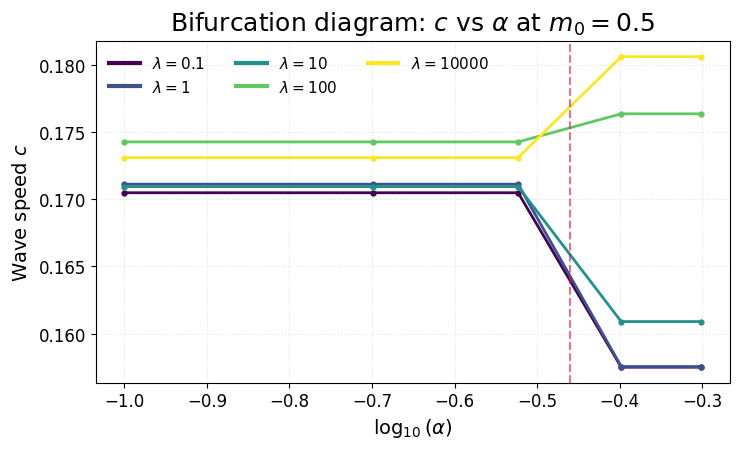

In [62]:
# ===========================
# bifurcation_from_results.py
# ===========================
import os, re, json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ---------- tolerant path helpers (same style as your other tools) ----------
_NUM_PAT = re.compile(r"([0-9eE.\-]+)$")

def _token_variants(v: float):
    v = float(v)
    dec   = f"{v:.12f}".rstrip("0").rstrip(".")
    plain = f"{v:g}"
    sci   = f"{v:.0e}"; s,e = sci.split("e"); sci_neat = f"{s}e{int(e)}"
    toks = {dec, plain, sci, sci_neat}
    toks |= {t.replace(".", "p") for t in list(toks)}  # allow 0p5-style
    return toks

def _exactish_dir(parent: Path, prefix: str, value: float):
    if not parent.exists(): return None
    for tok in _token_variants(value):
        p = parent / f"{prefix}_{tok}"
        if p.is_dir(): return p
    return None

def _closest_dir_by_number(parent: Path, prefix: str, target: float):
    if not parent.exists(): return None
    cands = [d for d in parent.iterdir() if d.is_dir() and d.name.startswith(prefix + "_")]
    if not cands: return None
    def take_num(p: Path):
        m = _NUM_PAT.search(p.name)
        try: return float(m.group(1)) if m else None
        except: return None
    pairs = [(p, take_num(p)) for p in cands]
    pairs = [(p,v) for p,v in pairs if v is not None]
    if not pairs: return None
    return min(pairs, key=lambda pv: abs(pv[1]-float(target)))[0]

def _augment_roots_by_m0(base_dirs, m0: float):
    """Prefer *_u when m0>=.5 else *_l, but honor a patch dir 'speeds_func_4' if present."""
    if isinstance(base_dirs, (str, os.PathLike)): base_dirs = (base_dirs,)
    roots = [str(b) for b in base_dirs]
    if os.path.isdir("speeds_func_4"):
        roots = ["speeds_func_4"] + roots
    want  = "speeds_func_u" if float(m0) >= 0.5 else "speeds_func_l"
    other = "speeds_func_l" if want == "speeds_func_u" else "speeds_func_u"
    ordered = [r for r in (want, other) if r in roots] + [r for r in roots if r not in (want, other)]
    # de-dup preserve order
    seen, out = set(), []
    for r in ordered:
        if r not in seen: seen.add(r); out.append(r)
    return tuple(out)

def _find_dir(base_dirs, lam, alpha, m0):
    """<root>/lambda_*/alpha_*/m0_* (exact-ish); lambda/alpha can fallback to nearest numeric."""
    roots = _augment_roots_by_m0(base_dirs, m0)
    for root in roots:
        base = Path(root)
        lam_dir = _exactish_dir(base, "lambda", lam) or _closest_dir_by_number(base, "lambda", lam)
        if lam_dir is None: continue
        a_dir = _exactish_dir(lam_dir, "alpha", alpha) or _closest_dir_by_number(lam_dir, "alpha", alpha)
        if a_dir is None: continue
        m_dir = _exactish_dir(a_dir, "m0", m0)   # m0 must match exactly-ish
        if m_dir is not None: return m_dir
    return None

def _summary_speed(run_dir: Path, which="N"):
    if run_dir is None: return np.nan
    s = run_dir / "summary.json"
    if not s.exists(): return np.nan
    try:
        meta = json.loads(s.read_text())
        keys = ("speed_N","c_N","wave_speed","speed","c") if str(which).upper()=="N" \
               else ("speed_M","c_M","wave_speed","speed","c")
        for k in keys:
            if k in meta:
                try:
                    v = float(meta[k])
                    if np.isfinite(v): return v
                except: pass
    except: pass
    return np.nan

# ---------------------- core loader: c(alpha | lambda, m0) ----------------------
def load_c_vs_alpha(
    base_dirs,
    lam,
    m0,
    alpha_values,
    which_speed="N",
    verbose=False
):
    """Return alphas (as float), speeds array (matching order), and a mask of finite points."""
    alphas = np.asarray(alpha_values, float)
    cvals  = np.full_like(alphas, np.nan, dtype=float)
    for i, a in enumerate(alphas):
        d = _find_dir(base_dirs, lam, a, m0)
        c = _summary_speed(d, which=which_speed)
        cvals[i] = c
        if verbose and not np.isfinite(c):
            print(f"[miss] λ={lam:g}, α={a:g}, m0={m0:g}")
    mask = np.isfinite(cvals)
    return alphas, cvals, mask

# --------------------------- plotting: bifurcation diagram ---------------------------
def plot_bifurcation_c_vs_alpha(
    base_dirs,
    lambdas,
    m0,
    alpha_values,
    which_speed="N",
    title=None,
    connect_valid_segments=True,
    mark_missing=True,
    tick_fs=12, label_fs=14, title_fs=18, legend_fs=11,
    suptitle=None,
    save=False, outpath=None
):
    """
    Draw c vs log10(alpha) curves for one m0 across multiple lambdas (one color per λ).
    • Mark missing (no solution / no result) points if mark_missing=True.
    • Connect only contiguous finite segments if connect_valid_segments=True.
    """
    lambdas = list(lambdas)
    colors = plt.cm.viridis(np.linspace(0, 1, len(lambdas)))

    fig, ax = plt.subplots(figsize=(7.5, 4.6))

    handles, labels = [], []
    for lam, col in zip(lambdas, colors):
        alphas, cvals, mask = load_c_vs_alpha(base_dirs, lam, m0, alpha_values, which_speed)
        x = np.log10(alphas)

        # draw contiguous finite segments
        if connect_valid_segments:
            # find segments of mask==True
            if mask.any():
                # indices where mask changes
                edges = np.diff(mask.astype(int), prepend=0, append=0)
                starts = np.where(edges == 1)[0]
                ends   = np.where(edges == -1)[0]
                for s,e in zip(starts, ends):
                    ax.plot(x[s:e], cvals[s:e], "-o", ms=3.5, lw=2.0, color=col)
            else:
                # nothing finite
                pass
        else:
            ax.plot(x[mask], cvals[mask], "o-", ms=3.5, lw=2.0, color=col)

        if mark_missing and (~mask).any():
            ax.plot(x[~mask], np.zeros_like(x[~mask]), "x", color=col, alpha=0.45, ms=5)

        h = ax.plot([], [], color=col, lw=3)[0]
        handles.append(h); labels.append(rf"$\lambda={lam:g}$")

    ax.set_xlabel(r"$\log_{10}(\alpha)$", fontsize=label_fs)
    ax.set_ylabel(r"Wave speed $c$", fontsize=label_fs)
    ttl = title or rf"Bifurcation diagram: $c$ vs $\alpha$ at $m_0={m0:g}$"
    ax.set_title(ttl, fontsize=title_fs, pad=8)
    ax.grid(True, ls=":", alpha=0.35)
    ax.tick_params(labelsize=tick_fs)
    ax.legend(handles, labels, fontsize=legend_fs, ncol=min(len(lambdas), 3), frameon=False)

    if suptitle:
        fig.suptitle(suptitle, fontsize=title_fs+2, weight="bold")

    fig.tight_layout()
    if save:
        outpath = outpath or f"bifurcation_c_vs_alpha_m0_{m0:g}.png"
        Path(outpath).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(outpath, dpi=300, bbox_inches="tight")
        print(f"[plot] saved: {outpath}")
    return fig, ax

# --------------------------- helper: mark “jump” locations ---------------------------
def annotate_largest_jump(ax, alphas, cvals, color="k"):
    """
    Put a vertical line at alpha where |Δc| is maximal (purely visual).
    """
    with np.errstate(all="ignore"):
        d = np.abs(np.diff(cvals))
    if not np.isfinite(d).any():
        return None
    i = int(np.nanargmax(d))
    if not np.isfinite(cvals[i]) or not np.isfinite(cvals[i+1]):
        return None
    a_mid = np.sqrt(alphas[i]*alphas[i+1])  # mid in log-scale
    x = np.log10(a_mid)
    ax.axvline(x, color=color, ls="--", lw=1.5, alpha=0.6)
    return a_mid

# ----------------------------------- examples -----------------------------------
if __name__ == "__main__":
    # Choose the store(s) you want to read. For your new scans use just:
    # base_dirs = ("speeds_func_alpha_01",)
    base_dirs = ("speeds_func_alpha_01","speeds_func_l","speeds_func_u","speeds_func_4")  # or ("speeds_func_l","speeds_func_u","speeds_func_4")

    # Use the alpha list you actually ran
    alpha_vals = [0.1, 0.2, 0.3, 0.4, 0.5]  # extend later when your new runs finish
    # Pick a few lambdas to overlay
    lambdas = [0.1, 1, 10, 100, 1e4]
    # Fix m0
    m0 = 0.5

    fig, ax = plot_bifurcation_c_vs_alpha(
        base_dirs=base_dirs,
        lambdas=lambdas,
        m0=m0,
        alpha_values=alpha_vals,
        which_speed="N",
        title=None,
        connect_valid_segments=True,
        mark_missing=True,
        tick_fs=12, label_fs=14, title_fs=18, legend_fs=11,
        save=True, outpath=f"bifurcation_c_vs_alpha_m0_{m0:g}.png"
    )

    # Optional: visually mark max jump for a specific λ series on this axis
    # (re-load one λ to compute the jump)
    lam_to_mark = lambdas[2]
    a, c, _ = load_c_vs_alpha(base_dirs, lam_to_mark, m0, alpha_vals, which_speed="N")
    annotate_largest_jump(ax, a, c, color="crimson")
    fig.canvas.draw_idle()

[plot] saved: bifurcation_c_vs_alpha_m0_0.1.png


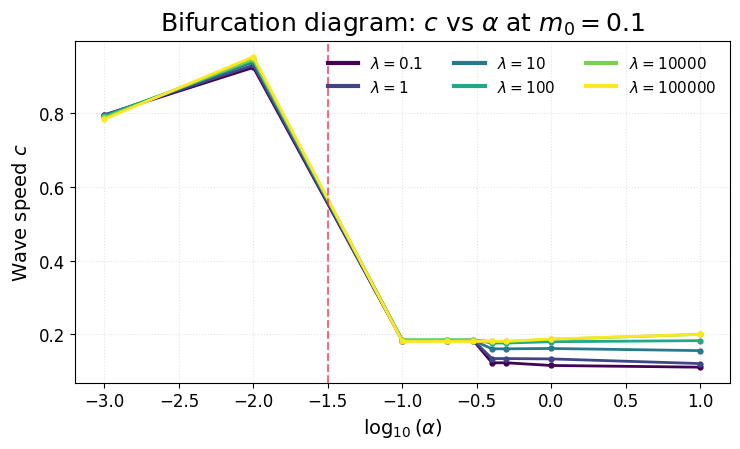

In [64]:
# ----------------------------------- examples -----------------------------------
if __name__ == "__main__":
    # Choose the store(s) you want to read. For your new scans use just:
    # base_dirs = ("speeds_func_alpha_01",)
    base_dirs = ("speeds_func_alpha_01","speeds_func_l","speeds_func_u","speeds_func_4")  # or ("speeds_func_l","speeds_func_u","speeds_func_4")

    # Use the alpha list you actually ran
    alpha_vals = [0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 1, 10]  # extend later when your new runs finish
    # Pick a few lambdas to overlay
    lambdas = [0.1, 1, 10, 100, 1e4, 1e5,]
    # Fix m0
    m0 = 0.1

    fig, ax = plot_bifurcation_c_vs_alpha(
        base_dirs=base_dirs,
        lambdas=lambdas,
        m0=m0,
        alpha_values=alpha_vals,
        which_speed="N",
        title=None,
        connect_valid_segments=True,
        mark_missing=True,
        tick_fs=12, label_fs=14, title_fs=18, legend_fs=11,
        save=True, outpath=f"bifurcation_c_vs_alpha_m0_{m0:g}.png"
    )

    # Optional: visually mark max jump for a specific λ series on this axis
    # (re-load one λ to compute the jump)
    lam_to_mark = lambdas[2]
    a, c, _ = load_c_vs_alpha(base_dirs, lam_to_mark, m0, alpha_vals, which_speed="N")
    annotate_largest_jump(ax, a, c, color="crimson")
    fig.canvas.draw_idle()

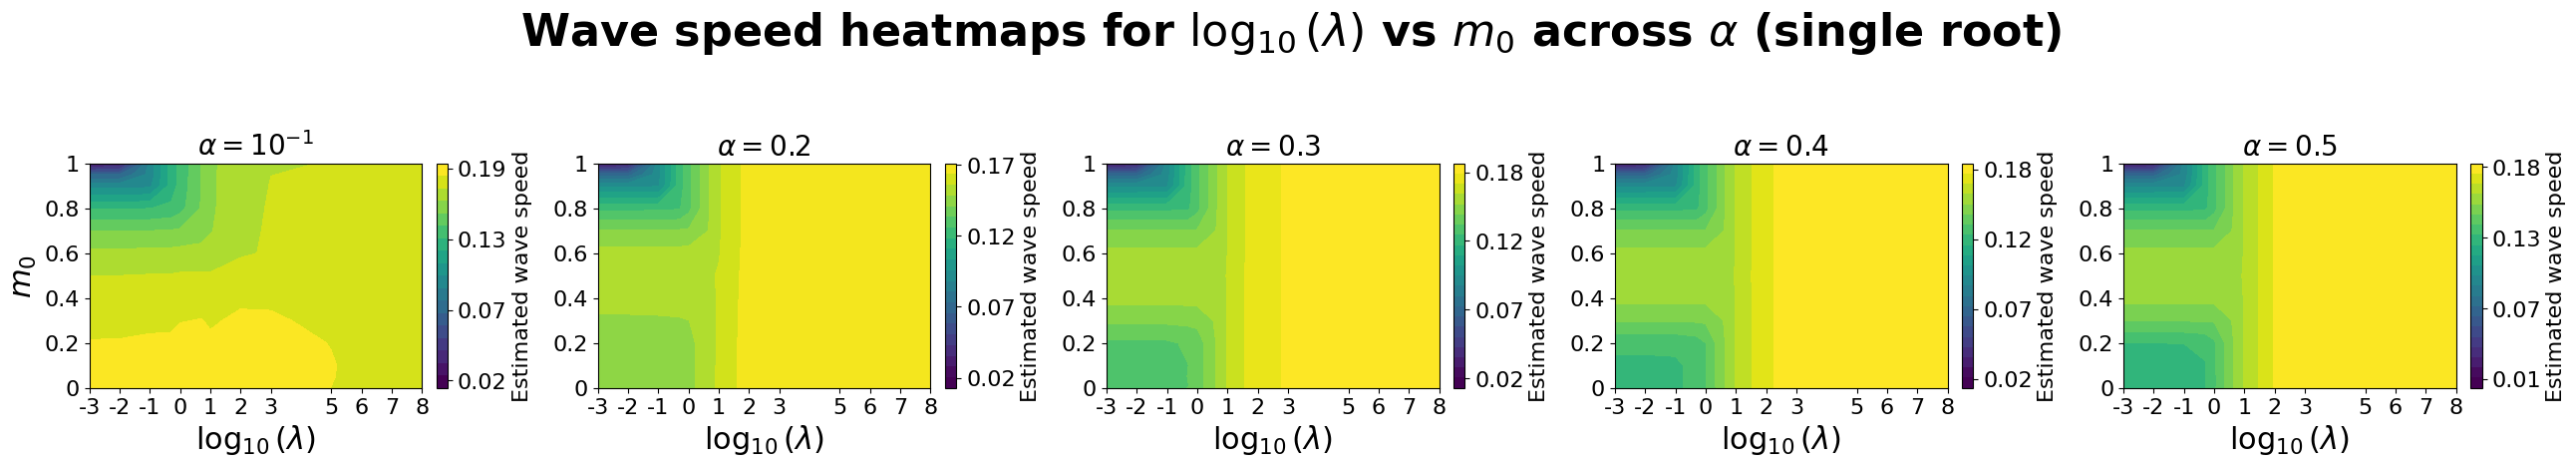

In [65]:
# === Wave-speed heatmaps for fixed α values (single root) =====================
# - Robust token matching: accepts 1e8, 1e+08, 1e08, 100000000, "p" decimals, E/ e.
# - Numeric fallback if exactish token not found.
# - 1×K grid over α in a single root like "speeds_func_alpha_01".
# ==============================================================================

import os, re, json
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt

# ------------------------
# Token + directory helpers
# ------------------------
_num_pat = re.compile(r"([0-9eE\.\+\-]+)$")

def _token_variants(v: float):
    """Return many textual variants for v to match folder tokens."""
    v = float(v)
    dec   = f"{v:.12f}".rstrip("0").rstrip(".")         # 100000000
    plain = f"{v:g}"                                    # 1e+08 or 100000000 (matplotlib-style)
    sci   = f"{v:.0e}"                                  # 1e+08
    s, e  = sci.split("e")
    ei    = int(e)                                      # 8 (or -8)
    sci_neat   = f"{s}e{ei}"                            # 1e8
    sci_zpad   = f"{s}e{abs(ei):02d}"                   # 1e08
    sci_sign   = f"{s}e{'+' if ei>=0 else '-'}{abs(ei):02d}"  # 1e+08 / 1e-08

    toks = {dec, plain, sci, sci_neat, sci_zpad, sci_sign}
    # uppercase E variants
    toks |= {t.replace("e", "E") for t in list(toks)}
    # allow decimal "p" variant (e.g., 0p5)
    toks |= {t.replace(".", "p") for t in list(toks)}
    return toks

def _exactish_dir(parent: Path, prefix: str, value: float):
    """Return parent/prefix_<token> if any token matches exactly (string)."""
    if not parent.exists():
        return None
    for tok in _token_variants(value):
        p = parent / f"{prefix}_{tok}"
        if p.is_dir():
            return p
    return None

def _closest_dir_by_number(parent: Path, prefix: str, target: float):
    """Numeric fallback (only used if exactish failed)."""
    if not parent.exists():
        return None
    cands = [d for d in parent.iterdir() if d.is_dir() and d.name.startswith(prefix + "_")]
    if not cands:
        return None
    def take_num(p: Path):
        m = _num_pat.search(p.name)
        if not m:
            return None
        s = m.group(1).replace("p", ".")
        # normalize e/E with optional + sign (float handles both)
        try:
            return float(s)
        except Exception:
            return None
    pairs = [(p, take_num(p)) for p in cands]
    pairs = [(p, v) for p, v in pairs if v is not None]
    if not pairs:
        return None
    return min(pairs, key=lambda pv: abs(pv[1] - float(target)))[0]

# ------------------------
# Speed loader
# ------------------------
def _summary_speed(run_dir: Path, which="N"):
    if run_dir is None:
        return np.nan
    s = run_dir / "summary.json"
    if not s.exists():
        return np.nan
    try:
        meta = json.loads(s.read_text())
    except Exception:
        return np.nan

    w = str(which).upper()
    keys = ["wave_speed", "speed", "c"]               # generic fallbacks
    if w == "N":
        keys = ["speed_N", "c_N"] + keys
    else:
        keys = ["speed_M", "c_M"] + keys

    for k in keys:
        if k in meta:
            try:
                v = float(meta[k])
                if np.isfinite(v):
                    return v
            except Exception:
                pass
    return np.nan

# ------------------------
# Single-root dir resolver
# ------------------------
def _find_dir_single_root(root_dir, lam, alpha, m0):
    """
    Resolve <root>/lambda_*/alpha_*/m0_* inside a single base folder.
    - tries exactish tokens first,
    - then numeric nearest for lambda and alpha,
    - m0 must match exactish (no nearest).
    """
    base = Path(root_dir)
    lam_dir = (_exactish_dir(base, "lambda", lam) or
               _closest_dir_by_number(base, "lambda", lam))
    if lam_dir is None:
        return None
    a_dir = (_exactish_dir(lam_dir, "alpha", alpha) or
             _closest_dir_by_number(lam_dir, "alpha", alpha))
    if a_dir is None:
        return None
    m_dir = _exactish_dir(a_dir, "m0", m0)  # exactish only for m0
    return m_dir

# ------------------------
# Plotter: 1×K grid over α
# ------------------------
def plot_alpha_grid_from_single_root(
    *,
    root_dir="speeds_func_alpha_01",
    alpha_list=(0.1, 0.2, 0.3, 0.4, 0.5),
    lambda_vals=(1e-3, 1e-2, 1e-1, 0.5, 1, 5, 10, 100, 1e3, 1e5, 1e6, 1e7, 1e8),
    m0_vals=(0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1),
    which_speed="N",
    cmap="viridis",
    levels=20,
    # fonts & layout
    tick_fs=16, label_fs=22, title_fs=20, cbar_fs=16,
    suptitle=r"Wave speed heatmaps for $\log_{10}(\lambda)$ vs $m_0$ across $\alpha$ (single root)",
    suptitle_y=1.02,
    every_other_y_tick=True,
    save=False, outpath=None,
    verbose=True
):
    alpha_list = tuple(float(a) for a in alpha_list)
    lam_arr    = np.asarray(lambda_vals, float)
    m0_arr     = np.asarray(m0_vals,     float)

    X, Y = np.meshgrid(np.log10(lam_arr), m0_arr)

    ncols = len(alpha_list)
    fig_w = 5.2 * ncols
    fig_h = 4.5
    fig, axes = plt.subplots(1, ncols, figsize=(fig_w, fig_h), squeeze=False)
    axes = axes[0]

    total_missing = 0

    for j, a in enumerate(alpha_list):
        ax = axes[j]
        H = np.full((len(m0_arr), len(lam_arr)), np.nan, float)

        # fill matrix
        for i, m0 in enumerate(m0_arr):
            for k, lam in enumerate(lam_arr):
                d = _find_dir_single_root(root_dir, lam, a, m0)
                c = _summary_speed(d, which=which_speed)
                if np.isfinite(c):
                    H[i, k] = c
                else:
                    total_missing += 1

        Hm = np.ma.masked_invalid(H)
        if np.isfinite(Hm).any():
            vmin, vmax = float(np.nanmin(Hm)), float(np.nanmax(Hm))
            if vmin == vmax:
                vmax = vmin + 1e-12
        else:
            vmin, vmax = 0.0, 1.0

        cf = ax.contourf(X, Y, Hm, levels=levels, cmap=cmap, vmin=vmin, vmax=vmax)

        # colorbar (4 ticks)
        cbar = fig.colorbar(cf, ax=ax, fraction=0.046, pad=0.04)
        ticks = [vmin,
                 vmin + (vmax - vmin) / 3.0,
                 vmin + 2.0 * (vmax - vmin) / 3.0,
                 vmax]
        cbar.set_ticks(ticks)
        cbar.set_ticklabels([f"{float(t):.2f}" for t in ticks])
        cbar.ax.tick_params(labelsize=cbar_fs)
        cbar.set_label("Estimated wave speed", fontsize=cbar_fs)

        # title
        if np.isclose(a, 1.0):
            tlabel = r"$\alpha=1$"
        elif np.isclose(a, 10.0):
            tlabel = r"$\alpha=10$"
        else:
            exp = int(np.floor(np.log10(abs(a)))) if a != 0 else 0
            mant = abs(a) / (10**exp) if a != 0 else 0
            if a != 0 and np.isclose(mant, 1.0):
                tlabel = rf"$\alpha=10^{{{exp}}}$"
            elif 1e-2 <= abs(a) <= 1e2:
                tlabel = rf"$\alpha={a:g}$"
            else:
                tlabel = rf"$\alpha={mant:.2g}\times 10^{{{exp}}}$"
        ax.set_title(tlabel, fontsize=title_fs)

        # axes labels
        ax.set_xlabel(r"$\log_{10}(\lambda)$", fontsize=label_fs)
        if j == 0:
            ax.set_ylabel(r"$m_0$", fontsize=label_fs)

        # ticks: decades on x; every-other on y if requested
        xticks = np.unique(np.floor(np.log10(lam_arr)).astype(int))
        ax.set_xticks(xticks)
        ax.set_xticklabels([f"{d:d}" for d in xticks], fontsize=tick_fs)

        yticks = np.linspace(0, 1, 11)  # coarse m0 grid for readability
        if every_other_y_tick:
            yticks = yticks[::2]  # 0, .2, .4, .6, .8, 1
        ax.set_yticks(yticks)
        ax.set_yticklabels([f"{y:.2g}" for y in yticks], fontsize=tick_fs)

    if suptitle:
        fig.suptitle(suptitle, fontsize=label_fs + 10, y=suptitle_y, fontweight="bold")

    fig.tight_layout(rect=[0, 0, 1, 0.93 if suptitle else 1])

    if verbose and total_missing:
        print(f"[info] missing/NaN cells encountered: {total_missing}")

    if save:
        outpath = outpath or "alpha_grid_single_root.png"
        Path(outpath).parent.mkdir(parents=True, exist_ok=True)
        fig.savefig(outpath, dpi=300, bbox_inches="tight")
        print(f"[plot] saved to {outpath}")
    else:
        plt.show()

    return fig, axes

# ------------------------
# Example call (your case)
# ------------------------
if __name__ == "__main__":
    lambda_vals = [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100, 1000, 100000, 1000000, 10000000, 100000000]
    alpha_vals  = [0.1, 0.2, 0.3, 0.4, 0.5]
    m0_vals     = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0]

    plot_alpha_grid_from_single_root(
        root_dir="speeds_func_alpha_01",
        alpha_list=alpha_vals,
        lambda_vals=lambda_vals,
        m0_vals=m0_vals,
        which_speed="N",
        cmap="viridis",
        levels=20,
        tick_fs=16, label_fs=22, title_fs=20, cbar_fs=16,
        suptitle=r"Wave speed heatmaps for $\log_{10}(\lambda)$ vs $m_0$ across $\alpha$ (single root)",
        suptitle_y=1.03,
        every_other_y_tick=True,
        save=False,  # set True to write a PNG
        outpath="alpha_grid_single_root.png",
        verbose=True
    )

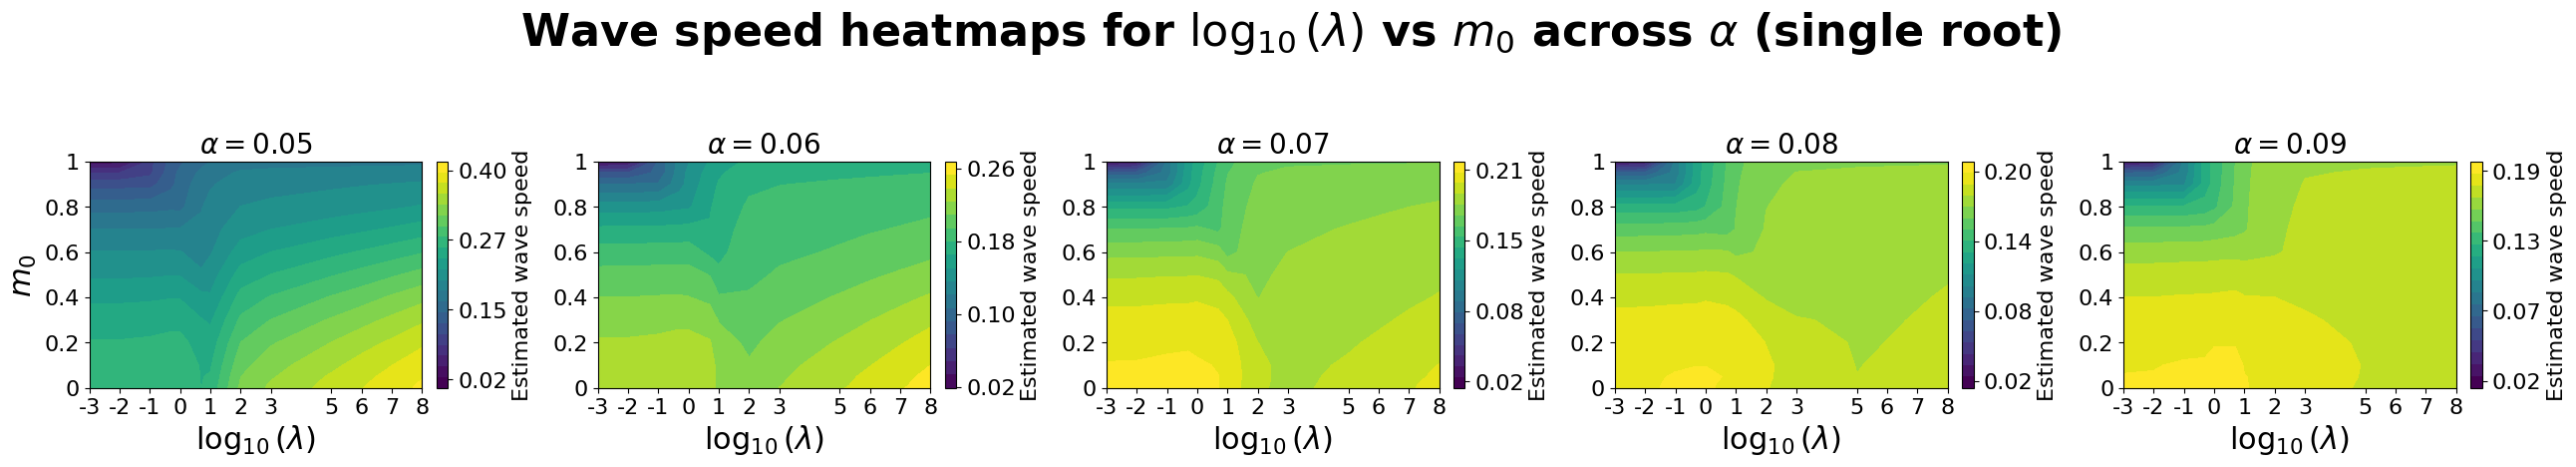

(<Figure size 2600x450 with 10 Axes>,
 array([<Axes: title={'center': '$\\alpha=0.05$'}, xlabel='$\\log_{10}(\\lambda)$', ylabel='$m_0$'>,
        <Axes: title={'center': '$\\alpha=0.06$'}, xlabel='$\\log_{10}(\\lambda)$'>,
        <Axes: title={'center': '$\\alpha=0.07$'}, xlabel='$\\log_{10}(\\lambda)$'>,
        <Axes: title={'center': '$\\alpha=0.08$'}, xlabel='$\\log_{10}(\\lambda)$'>,
        <Axes: title={'center': '$\\alpha=0.09$'}, xlabel='$\\log_{10}(\\lambda)$'>],
       dtype=object))

In [66]:
lambda_vals = [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100, 1000, 100000, 1000000, 10000000, 100000000]
alpha_vals  = [0.05, 0.06, 0.07, 0.08, 0.09]
m0_vals     = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0]
plot_alpha_grid_from_single_root(
    root_dir="speeds_func_alpha_001",
    alpha_list=alpha_vals,
    lambda_vals=lambda_vals,
    m0_vals=m0_vals,
    which_speed="N",
    cmap="viridis",
    levels=20,
    tick_fs=16, label_fs=22, title_fs=20, cbar_fs=16,
    suptitle=r"Wave speed heatmaps for $\log_{10}(\lambda)$ vs $m_0$ across $\alpha$ (single root)",
    suptitle_y=1.03,
    every_other_y_tick=True,
    save=False,  # set True to write a PNG
    outpath="alpha_grid_single_root.png",
    verbose=True
    )

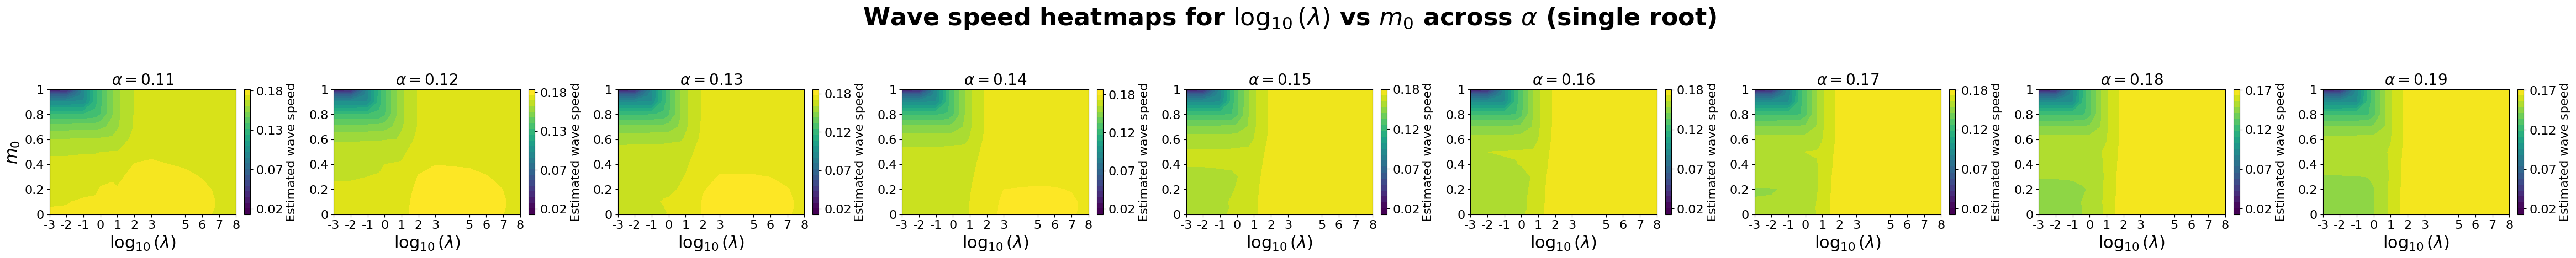

(<Figure size 4680x450 with 18 Axes>,
 array([<Axes: title={'center': '$\\alpha=0.11$'}, xlabel='$\\log_{10}(\\lambda)$', ylabel='$m_0$'>,
        <Axes: title={'center': '$\\alpha=0.12$'}, xlabel='$\\log_{10}(\\lambda)$'>,
        <Axes: title={'center': '$\\alpha=0.13$'}, xlabel='$\\log_{10}(\\lambda)$'>,
        <Axes: title={'center': '$\\alpha=0.14$'}, xlabel='$\\log_{10}(\\lambda)$'>,
        <Axes: title={'center': '$\\alpha=0.15$'}, xlabel='$\\log_{10}(\\lambda)$'>,
        <Axes: title={'center': '$\\alpha=0.16$'}, xlabel='$\\log_{10}(\\lambda)$'>,
        <Axes: title={'center': '$\\alpha=0.17$'}, xlabel='$\\log_{10}(\\lambda)$'>,
        <Axes: title={'center': '$\\alpha=0.18$'}, xlabel='$\\log_{10}(\\lambda)$'>,
        <Axes: title={'center': '$\\alpha=0.19$'}, xlabel='$\\log_{10}(\\lambda)$'>],
       dtype=object))

In [68]:
lambda_vals = [0.001, 0.01, 0.1, 0.5, 1, 5, 10, 100, 1000, 100000, 1000000, 10000000, 100000000]
alpha_vals  = [0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19]
m0_vals     = [0, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99, 1.0]
plot_alpha_grid_from_single_root(
    root_dir="speeds_func_alpha_011",
    alpha_list=alpha_vals,
    lambda_vals=lambda_vals,
    m0_vals=m0_vals,
    which_speed="N",
    cmap="viridis",
    levels=20,
    tick_fs=16, label_fs=22, title_fs=20, cbar_fs=16,
    suptitle=r"Wave speed heatmaps for $\log_{10}(\lambda)$ vs $m_0$ across $\alpha$ (single root)",
    suptitle_y=1.03,
    every_other_y_tick=True,
    save=False,  # set True to write a PNG
    outpath="alpha_grid_single_root.png",
    verbose=True
)